In [216]:
import sys
sys.path.append(r'D:\github\ripple_heterogeneity\python')
import replay_rank_order
import functions,loading
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import importlib
import glob
import os
import pickle
import replay_fig
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random

In [217]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## main analysis

In [218]:
importlib.reload(replay_rank_order)

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'
sessions = glob.glob(save_path +os.sep+ '*.pkl')
df = pd.DataFrame()
df['basepath'] = sessions

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_rank_order'
replay_rank_order.main(df,save_path,parallel=True)

df_rank_order = replay_rank_order.load_results(save_path)


## remove cells that were active in < 5 replay events in the epoch

Can not estimate rank order from so few

In [219]:
df_rank_order = df_rank_order[df_rank_order.n_active_replays >= 5]

In [220]:
df_rank_order.loc[df_rank_order.environment == 0,'environment'] = 'pre'
df_rank_order.loc[df_rank_order.environment == 1,'environment'] = 'task'
df_rank_order.loc[df_rank_order.environment == 2,'environment'] = 'post'

In [221]:
df_rank_order['label_env'] = df_rank_order.label +'_'+df_rank_order.environment

## rank order to avg fr

In [ ]:
group_colors = {"Deep": '#7b3294',
            'Superficial': '#008837'} 
sns.set_palette(sns.color_palette(group_colors.values()))

sns.lmplot(x="median_rank_order", y="avg_fr", col="label_env", hue="deepSuperficial",hue_order=group_colors.keys(), data=df_rank_order,
            col_wrap=4, height=3.5,
            scatter_kws={"s": 25, "alpha": 1})
plt.yscale('log')
plt.savefig(os.path.join(fig_save_path,'rank_order_firing_rate_.pdf'),dpi=300,bbox_inches='tight')


## rank order to ripple participation 

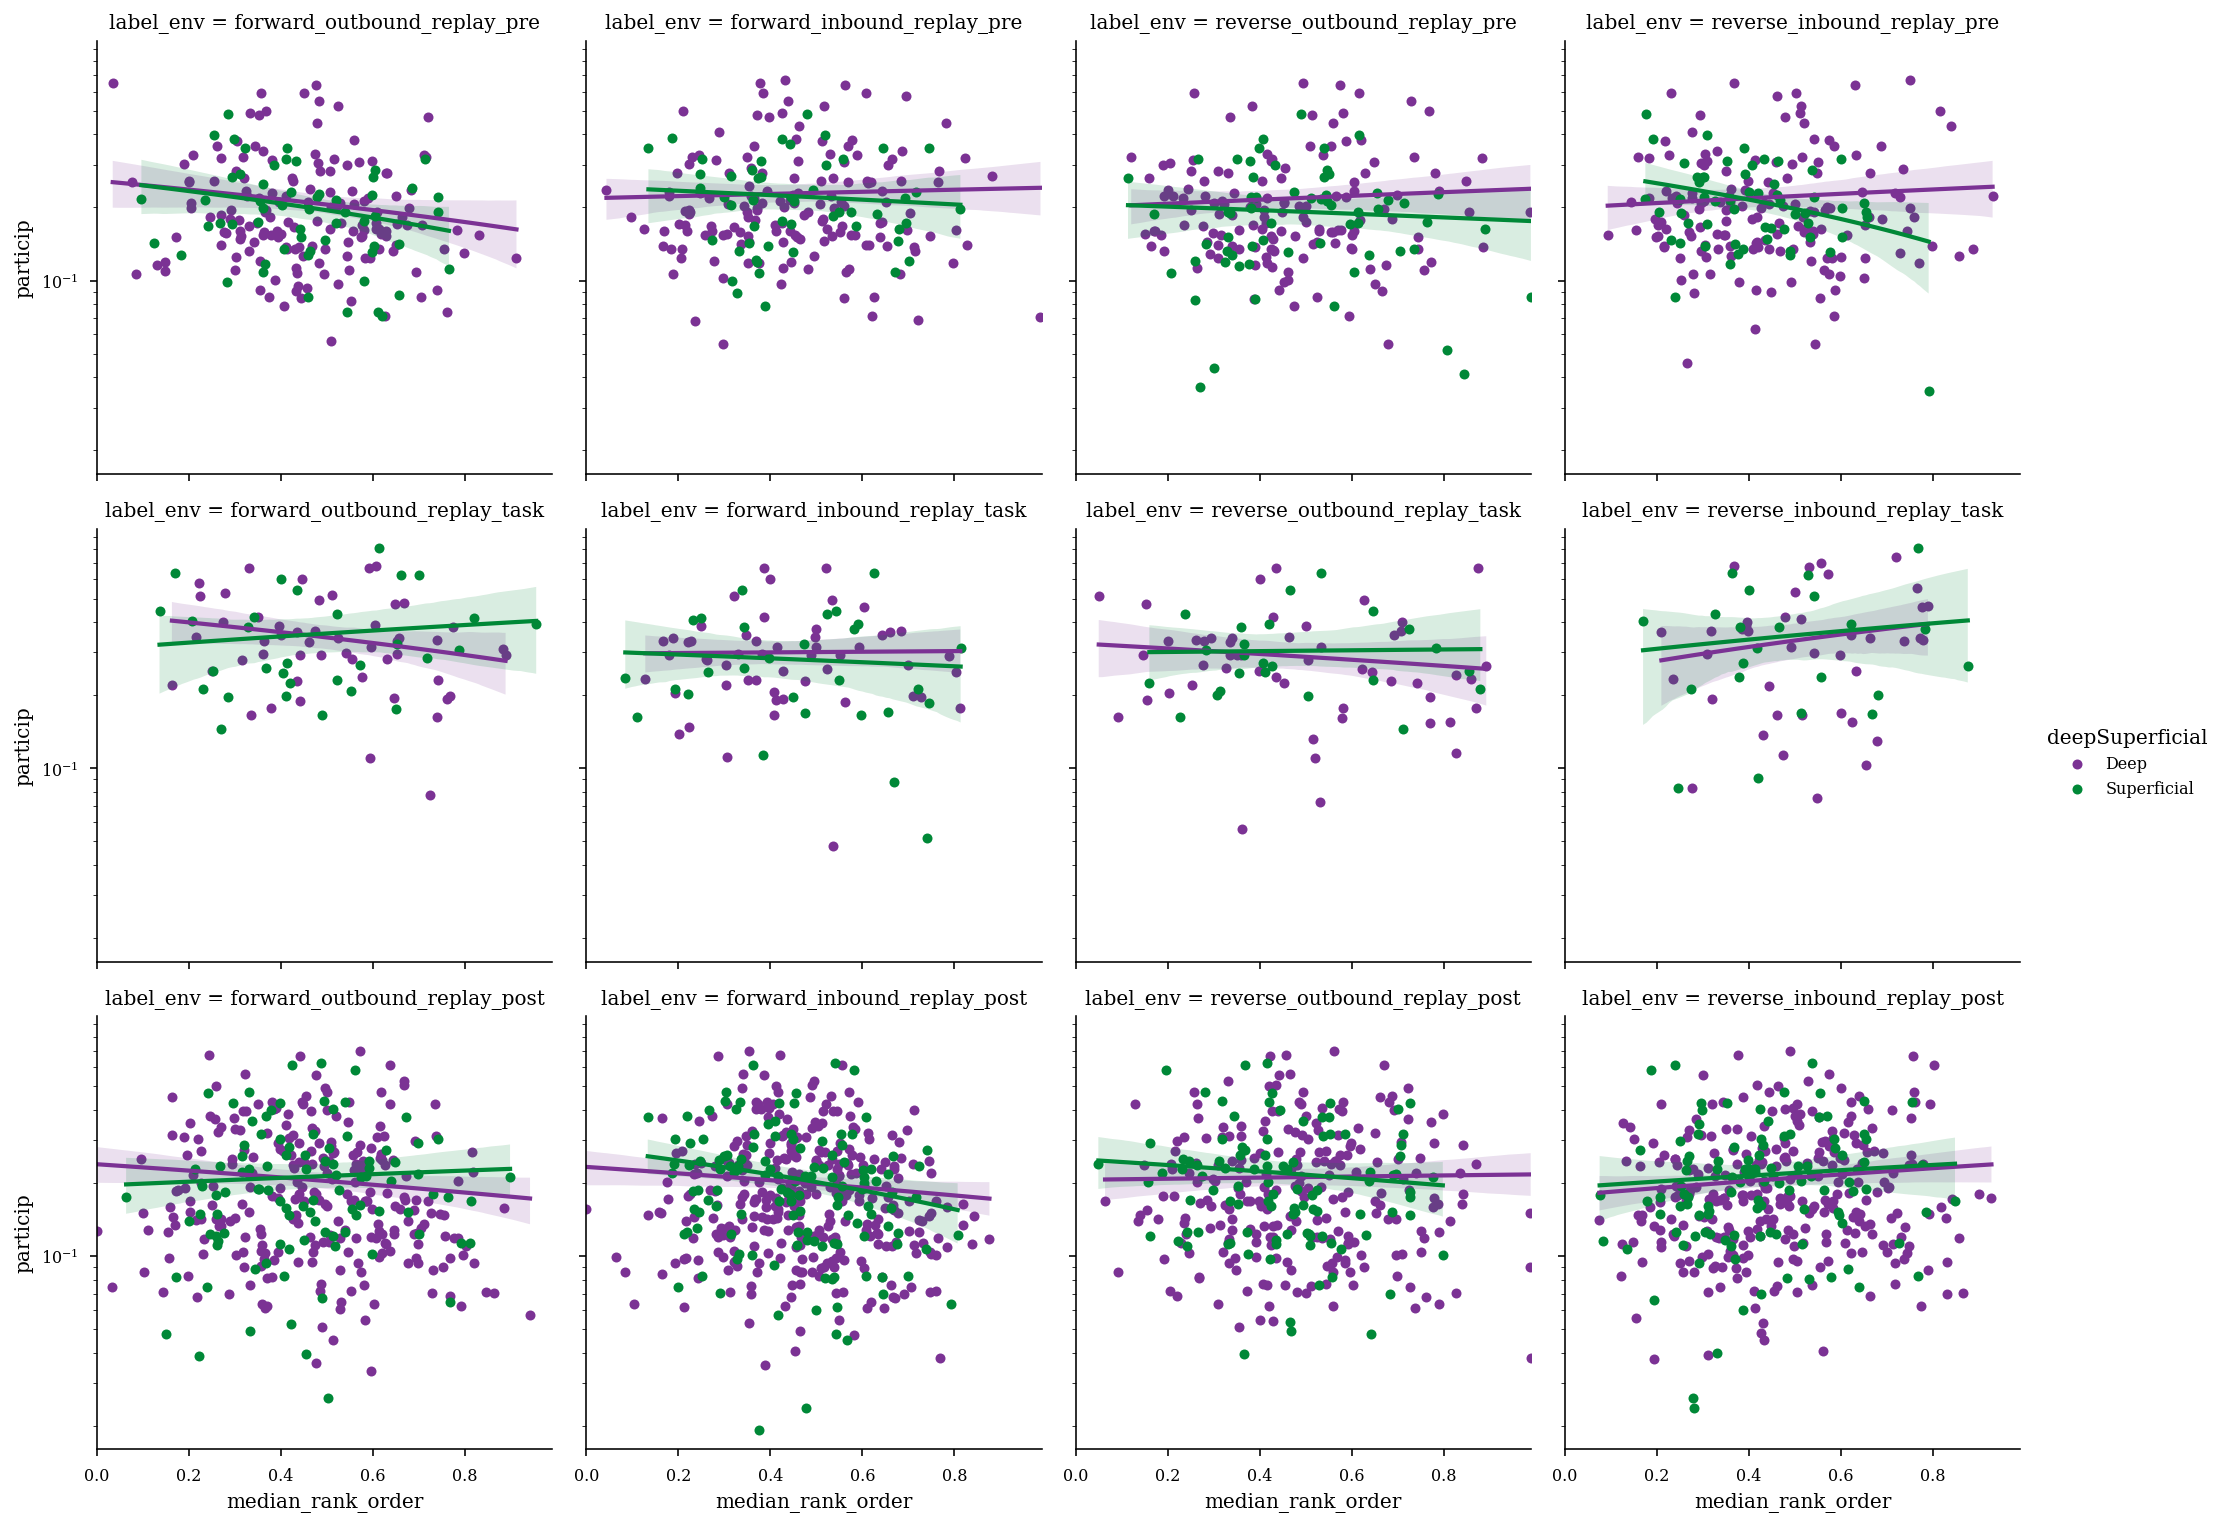

In [ ]:
group_colors = {"Deep": '#7b3294',
            'Superficial': '#008837'} 
sns.set_palette(sns.color_palette(group_colors.values()))


sns.lmplot(x="median_rank_order", y="particip", col="label_env", hue="deepSuperficial",hue_order=group_colors.keys(), data=df_rank_order,
            col_wrap=4, height=3.5,
            scatter_kws={"s": 25, "alpha": 1})
plt.yscale('log')
plt.savefig(os.path.join(fig_save_path,'rank_order_ripple_participation.pdf'),dpi=300,bbox_inches='tight')


## rank order by replay participation

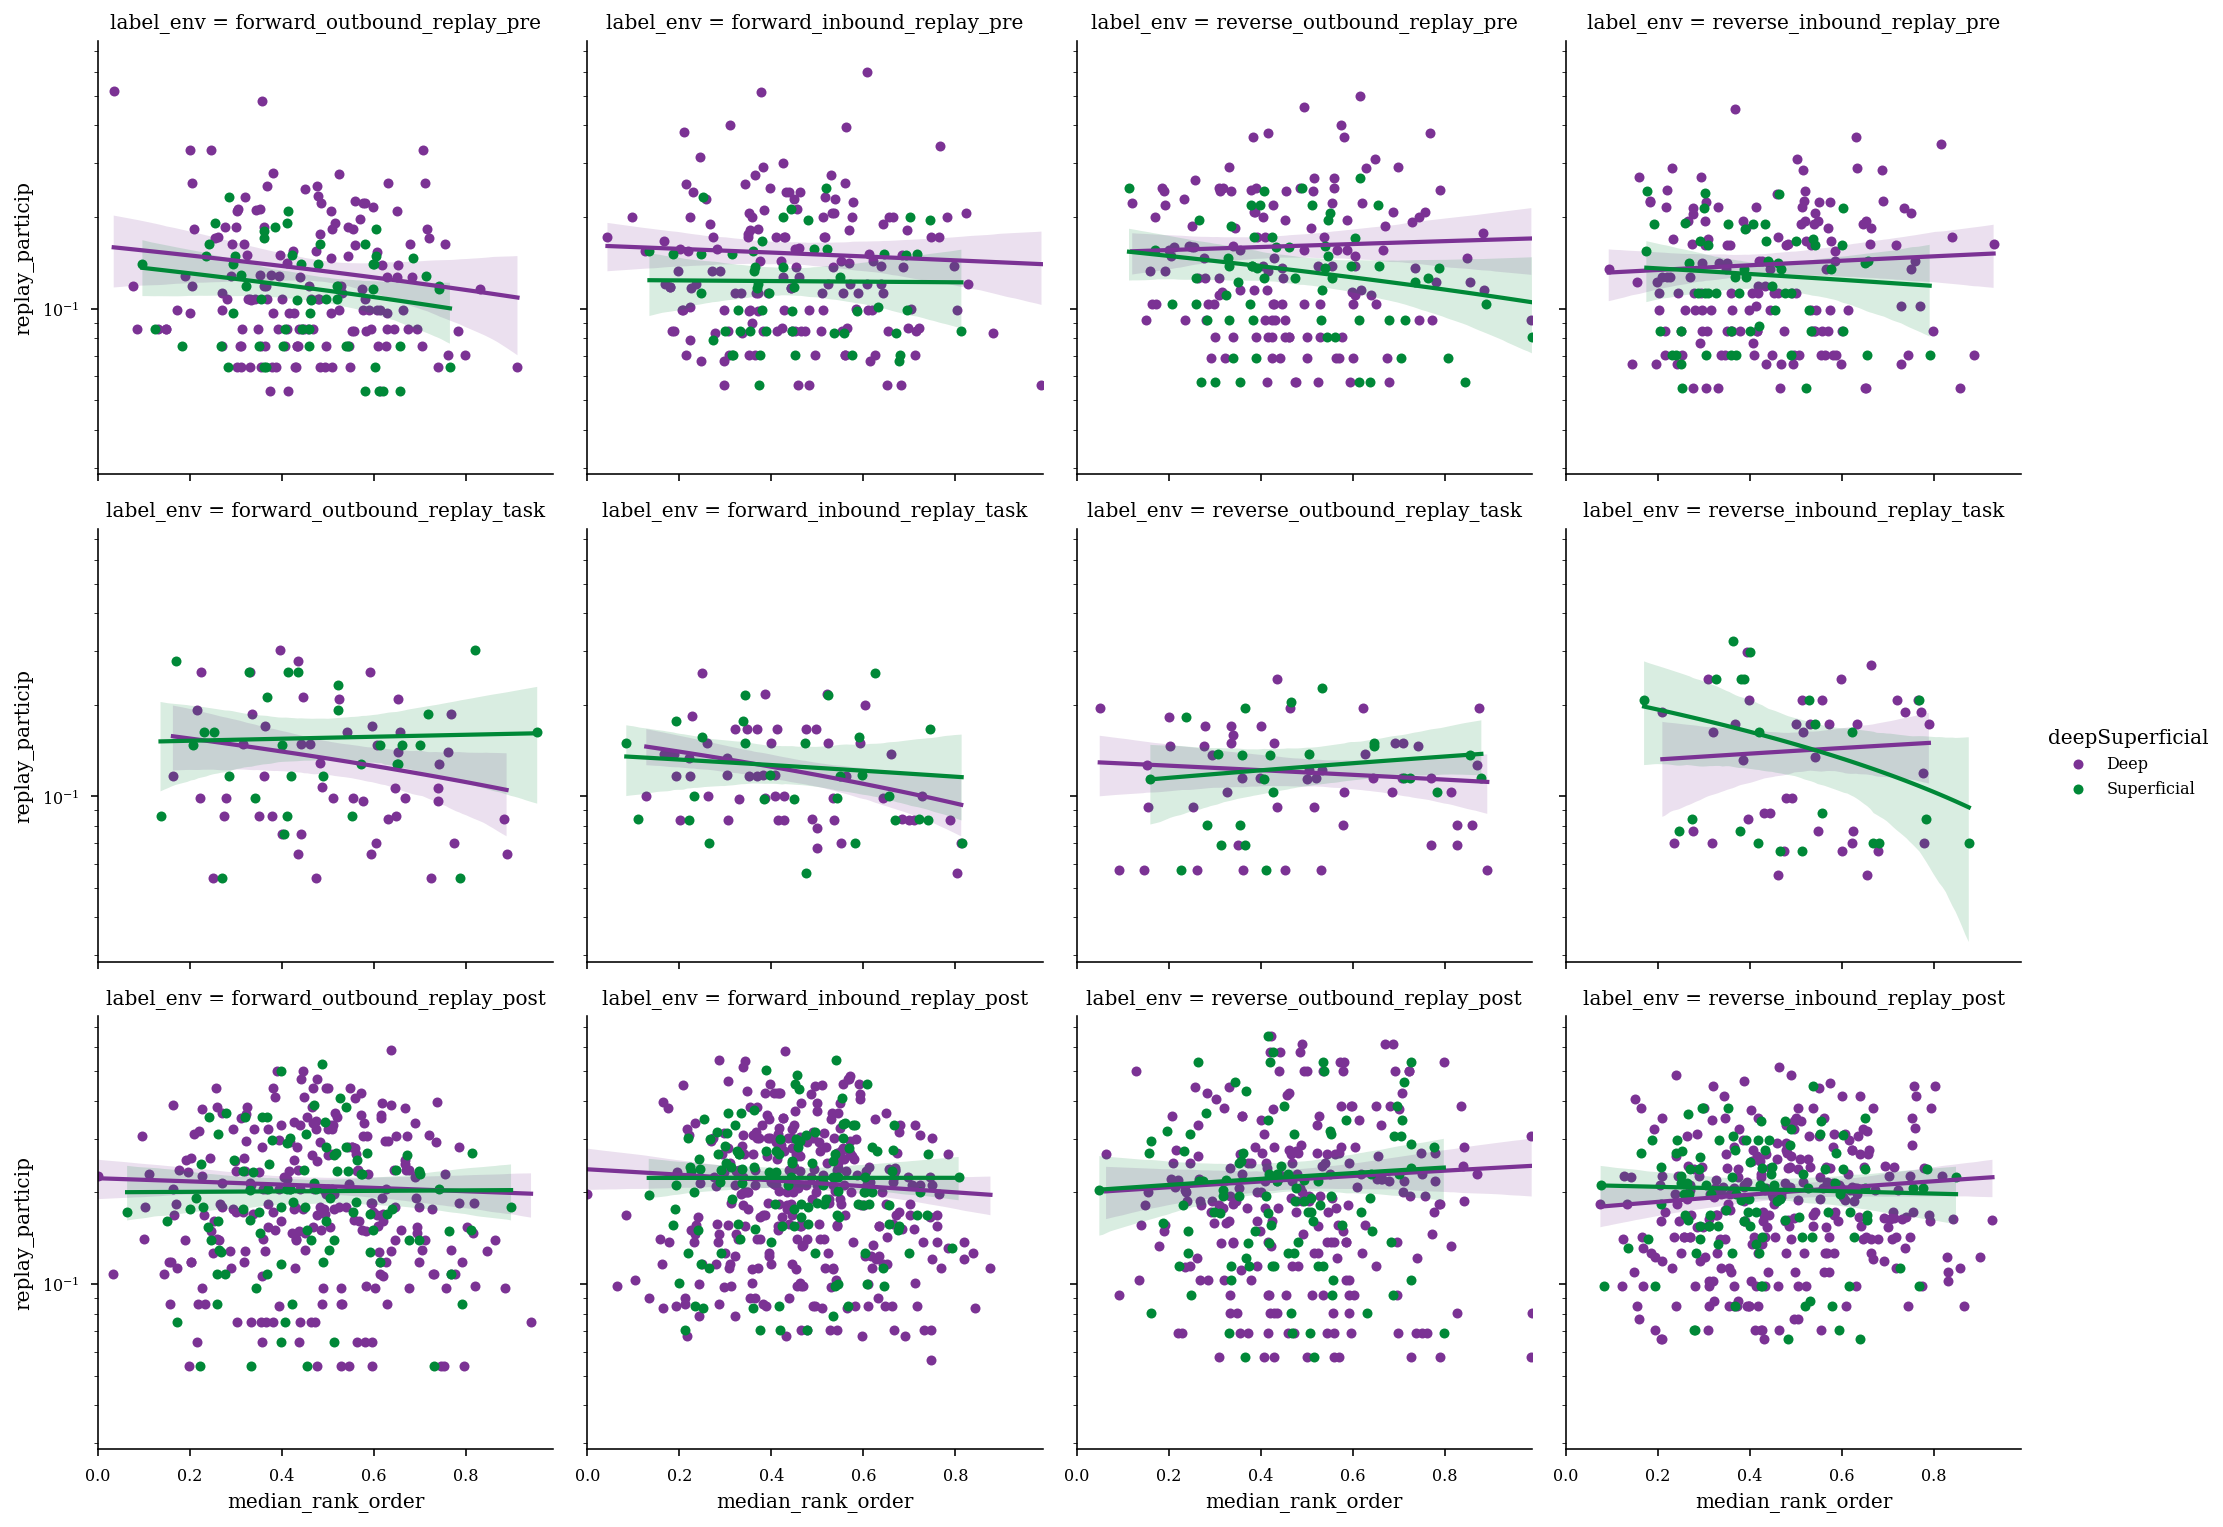

In [ ]:
group_colors = {"Deep": '#7b3294',
            'Superficial': '#008837'} 
sns.set_palette(sns.color_palette(group_colors.values()))

sns.lmplot(x="median_rank_order", y="replay_particip", col="label_env", hue="deepSuperficial",hue_order=group_colors.keys(), data=df_rank_order,
            col_wrap=4, height=3.5,
            scatter_kws={"s": 25, "alpha": 1})
plt.yscale('log')

plt.savefig(os.path.join(fig_save_path,'rank_order_replay_participation.pdf'),dpi=300,bbox_inches='tight')


## See if there is a positive correlation of rank order in forward and reverse replays. 

This would be a strong support for the role of cell excitability in organizing the structure of sequences in the deep subpopulation.

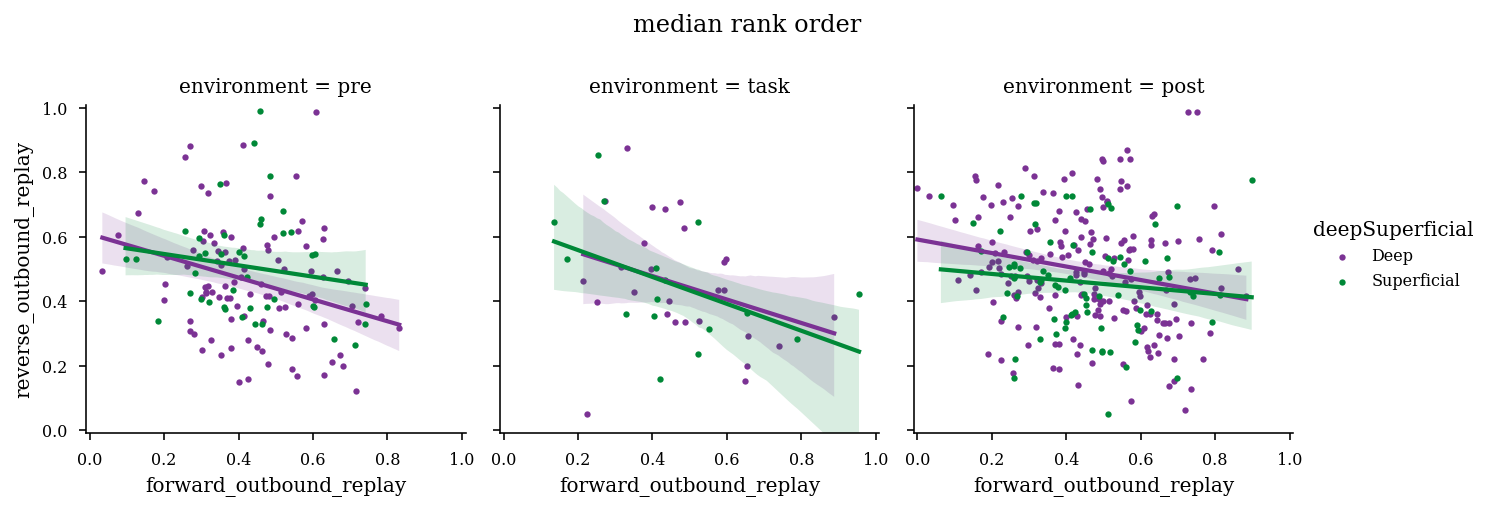

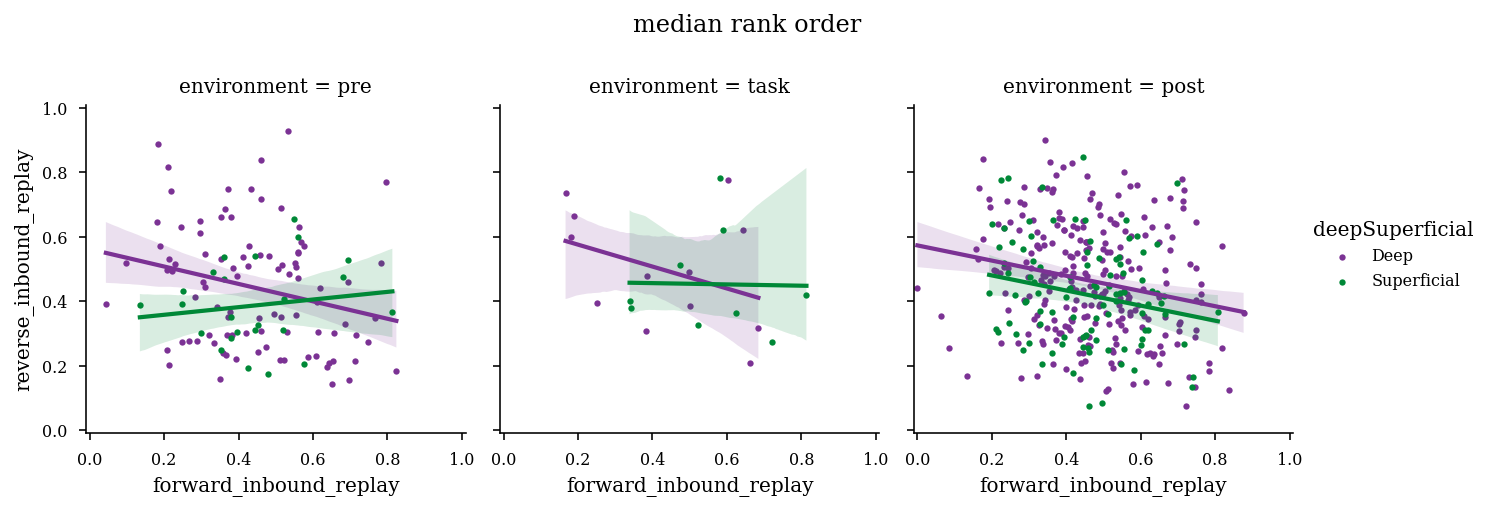

In [ ]:
df_rank_order_pivot = df_rank_order.pivot(index=['UID','deepSuperficial','environment','basepath'], columns='label', values='median_rank_order')
df_rank_order_pivot = df_rank_order_pivot.reset_index(level=['UID', 'deepSuperficial','environment','basepath'])

g = sns.lmplot(
    data=df_rank_order_pivot,
    x="forward_outbound_replay", y="reverse_outbound_replay", hue="deepSuperficial",col='environment',col_order=['pre','task','post'],
    height=3,scatter_kws={"s": 10, "alpha": 1}
)
g.fig.suptitle('median rank order',y=1.1)
g.set(xlim=(-0.01, 1.01), ylim=(-0.01, 1.01))

plt.savefig(os.path.join(fig_save_path,'forward_outbound_replay_reverse_outbound_replay.pdf'),dpi=300,bbox_inches='tight')

g = sns.lmplot(
    data=df_rank_order_pivot,
    x="forward_inbound_replay", y="reverse_inbound_replay", hue="deepSuperficial",col='environment',col_order=['pre','task','post'],
    height=3,scatter_kws={"s": 10, "alpha": 1}
)
g.fig.suptitle('median rank order',y=1.1)
g.set(xlim=(-0.01, 1.01), ylim=(-0.01, 1.01))

plt.savefig(os.path.join(fig_save_path,'forward_inbound_replay_reverse_inbound_replay.pdf'),dpi=300,bbox_inches='tight')


## See if excitability is correlated with template order for each replay dir

In [ ]:
from scipy import stats

def get_the_correlation(idx,st,tc_placecells,median_rank_order):
    if sum(idx) < 3:
        return [np.nan,np.nan]
    place_order = np.array(tc_placecells[idx].get_peak_firing_order_ids())
    temporal_order = np.array(st.series_ids)[idx][(np.argsort(median_rank_order[idx])).astype(int)]
    return stats.pearsonr(np.argsort(place_order),np.argsort(temporal_order))

def extract_temporal_spatial_order(results,template_dir):
    tc_placecells = results[template_dir]['tc']
    st = results[template_dir]['sta_placecells']
    cell_metrics = results[template_dir]['cell_metrics']

    space_temp_corr = []
    space_temp_corr_pval = []
    space_temp_corr_deep = []
    space_temp_corr_pval_deep = []
    space_temp_corr_sup = []
    space_temp_corr_pval_sup = []

    epoch_df,behavior_epochs = replay_rank_order.get_pre_linear_post(results[template_dir]['session'])

    sig_df = results[template_dir]['df'][results[template_dir]['df'].score_pval_time_swap < 0.05].copy()
    sig_df['environment'] = 'unknown'
    sig_df.loc[sig_df['start'].between(epoch_df.iloc[0].startTime,epoch_df.iloc[0].stopTime),'environment'] = 'pre'
    sig_df.loc[sig_df['start'].between(epoch_df.iloc[1].startTime,epoch_df.iloc[1].stopTime),'environment'] = 'task'
    sig_df.loc[sig_df['start'].between(epoch_df.iloc[2].startTime,epoch_df.iloc[2].stopTime),'environment'] = 'post'

    if sig_df.shape[0] == 0:
        return sig_df
    for temp_df in sig_df.itertuples():
        replay_epochs = nel.EpochArray(np.array([temp_df.start,temp_df.stop]).T)
        median_rank_order,_ = functions.get_rank_order(st,replay_epochs)

        good_idx = st[replay_epochs].n_events > 0
        
        place_order = np.array(tc_placecells[good_idx].get_peak_firing_order_ids())
        temporal_order = np.array(st.series_ids)[good_idx][(np.argsort(median_rank_order[good_idx])).astype(int)]

        corr,pval = stats.pearsonr(np.argsort(place_order),np.argsort(temporal_order))

        space_temp_corr.append(corr)
        space_temp_corr_pval.append(pval)

        idx = good_idx & (cell_metrics.deepSuperficial.values == 'Deep')
        corr_deep,pval_deep = get_the_correlation(idx,st,tc_placecells,median_rank_order)
        space_temp_corr_deep.append(corr_deep)
        space_temp_corr_pval_deep.append(pval_deep)

        idx = good_idx & (cell_metrics.deepSuperficial.values == 'Superficial')
        corr_sup,pval_sup = get_the_correlation(idx,st,tc_placecells,median_rank_order)
        space_temp_corr_sup.append(corr_sup)
        space_temp_corr_pval_sup.append(pval_sup)

    sig_df['space_temp_corr'] = np.hstack(space_temp_corr)
    sig_df['space_temp_corr_pval'] = np.hstack(space_temp_corr_pval)
    sig_df['space_temp_corr_deep'] = np.hstack(space_temp_corr_deep)
    sig_df['space_temp_corr_pval_deep'] = np.hstack(space_temp_corr_pval_deep)
    sig_df['space_temp_corr_sup'] = np.hstack(space_temp_corr_sup)
    sig_df['space_temp_corr_pval_sup'] = np.hstack(space_temp_corr_pval_sup)
    return sig_df

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'
sessions = glob.glob(save_path +os.sep+ '*.pkl')

excit_df = pd.DataFrame()
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)
    
    sig_df = extract_temporal_spatial_order(results,'outbound_epochs')
    sig_df['template_dir'] = 'outbound_epochs'
    excit_df = pd.concat([excit_df,sig_df],ignore_index=True)

    sig_df = extract_temporal_spatial_order(results,'inbound_epochs')
    sig_df['template_dir'] = 'inbound_epochs'
    excit_df = pd.concat([excit_df,sig_df],ignore_index=True)

excit_df = excit_df[~(excit_df.replay_type == 'unknown')]
excit_df = excit_df[~(excit_df.environment == 'unknown')]


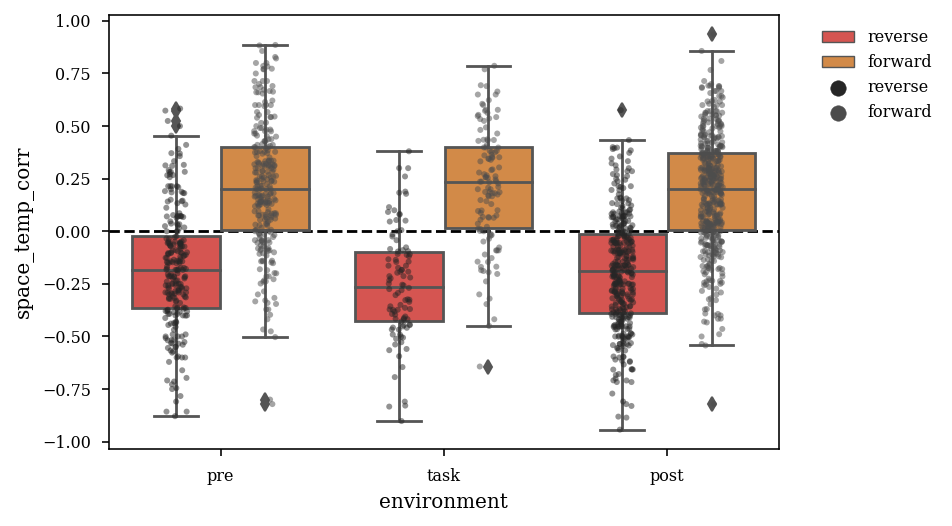

In [ ]:
sns.boxplot(x="environment", y="space_temp_corr",hue='replay_type',
            data=excit_df)
plt.axhline(0,color='k',linestyle='--',zorder=-10)

sns.stripplot(x="environment", y="space_temp_corr",hue='replay_type',
            data=excit_df,
            size=3, color=".3",alpha=.5, linewidth=0,dodge=True)
plt.legend(bbox_to_anchor=(.75, 0, 0.5, 1),frameon=False)


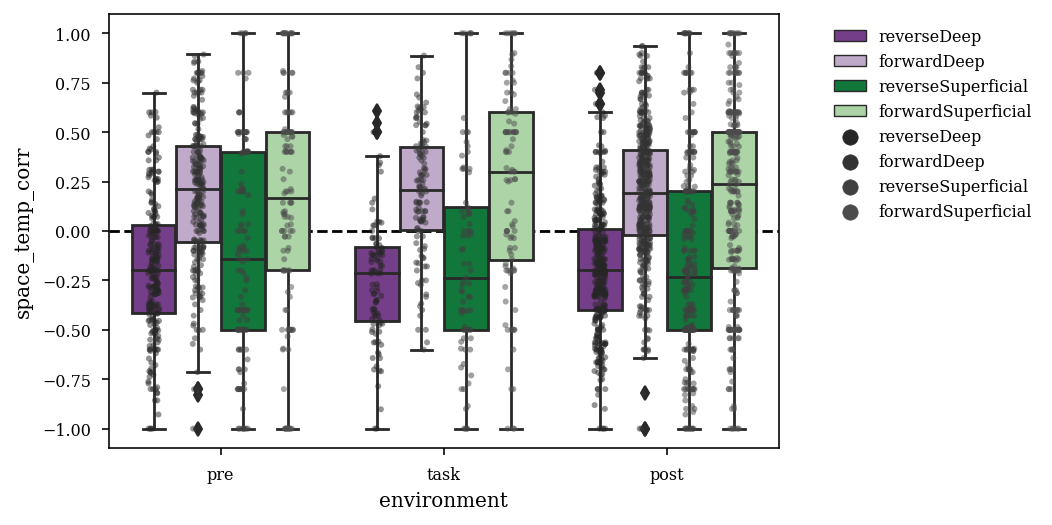

In [ ]:
excit_df_long = pd.DataFrame()
excit_df_long['space_temp_corr'] = np.hstack([excit_df.space_temp_corr_deep.values,excit_df.space_temp_corr_sup.values])
excit_df_long['space_temp_corr_pval'] = np.hstack([excit_df.space_temp_corr_pval_deep.values,excit_df.space_temp_corr_pval_sup.values])
excit_df_long['replay_type'] = np.hstack([excit_df.replay_type.values,excit_df.replay_type.values])
excit_df_long['environment'] = np.hstack([excit_df.environment.values,excit_df.environment.values])
excit_df_long['deepSuperficial'] = np.hstack([['Deep']*len(excit_df.replay_type),['Superficial']*len(excit_df.replay_type)])

excit_df_long['replay_type_layer'] = excit_df_long['replay_type'] + excit_df_long['deepSuperficial']

group_colors = {"reverseDeep": '#7b3294',
            "forwardDeep": '#c2a5cf',
            'reverseSuperficial': '#008837',
            'forwardSuperficial': '#a6dba0'} 
sns.set_palette(sns.color_palette(group_colors.values()))

plt.axhline(0,color='k',linestyle='--',zorder=-10)

sns.stripplot(x="environment", y="space_temp_corr",hue='replay_type_layer',hue_order=group_colors.keys(),data=excit_df_long,
            size=3, color=".3",alpha=.5, linewidth=0,dodge=True)

sns.boxplot(x="environment", y="space_temp_corr",hue='replay_type_layer',hue_order=group_colors.keys(),data=excit_df_long)

plt.legend(bbox_to_anchor=(.9, 0, 0.5, 1),frameon=False)

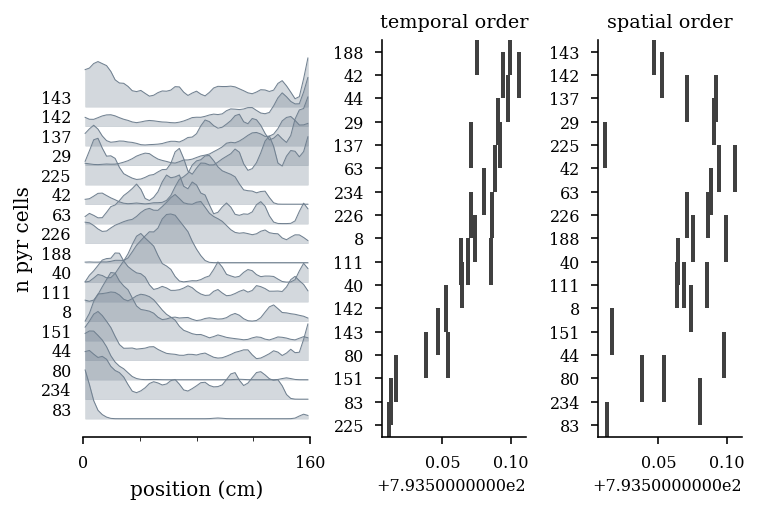

In [187]:
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

with open(sessions[0], 'rb') as f:
    results = pickle.load(f)

tc_placecells = results['outbound_epochs']['tc']
st = results['outbound_epochs']['sta_placecells']
cell_metrics = results['outbound_epochs']['cell_metrics']

idxs = np.where((results['outbound_epochs']['df'].score_pval_time_swap < 0.05) & (results['outbound_epochs']['df'].replay_type == 'forward'))
idx = int(idxs[0][1])

replays = results['outbound_epochs']['df'].iloc[idx]
replay_epochs = nel.EpochArray(np.array([replays.start,replays.stop]).T)
median_rank_order,rank_order = functions.get_rank_order(st,replay_epochs)

good_idx = st[replay_epochs].n_events > 0
active_st = st._unit_subset(np.array(st.series_ids)[good_idx]).copy()

active_median_rank_order = median_rank_order[good_idx]

w,h = functions.set_size('thesis', fraction=1, subplots=(1,1))
active_tc_placecells = tc_placecells._unit_subset(np.array(st.series_ids)[good_idx])

npl.set_palette(npl.colors.rainbow)
with npl.FigureManager(show=True, figsize=(w,h)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    tc = active_tc_placecells.reorder_units()
    ax1 = npl.plot_tuning_curves1D(tc, normalize=True, pad=.4,fill=True,color='slategrey')
    leg_lines = ax1.get_lines()
    plt.setp(leg_lines, linewidth=.5)
    ax.set_xlabel('position (cm)')
    ax.set_ylabel('n pyr cells')
    ax.set_xticks([0,tc.bins.max()])
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    divider = make_axes_locatable(ax)
    temp_order_ax = divider.append_axes("right", size=1, pad=.5)
    npl.rasterplot(active_st[replay_epochs].reorder_series_by_ids(np.array(active_st.series_ids)[np.argsort(active_median_rank_order)]), 
                vertstack=True, lh=2,lw=2,ax=temp_order_ax)
    temp_order_ax.set_title('temporal order')            

    space_order_ax = divider.append_axes("right", size=1, pad=.5)
    active_tc_placecells = tc_placecells._unit_subset(np.array(st.series_ids)[good_idx])
    no = active_tc_placecells.get_peak_firing_order_ids()
    npl.rasterplot(active_st[replay_epochs].reorder_series_by_ids(no), 
                vertstack=True, lh=2,lw=2,ax=space_order_ax)
    space_order_ax.set_title('spatial order')  


    npl.utils.clear_right(space_order_ax)
    npl.utils.clear_top(space_order_ax)   

    npl.utils.clear_right(temp_order_ax)
    npl.utils.clear_top(temp_order_ax)     

In [186]:
1-.4

0.6

In [149]:
# tc_placecells = results['outbound_epochs']['tc']
# st = results['outbound_epochs']['sta_placecells']
# cell_metrics = results['outbound_epochs']['cell_metrics']
# bst = results['outbound_epochs']['bst_placecells']

# idxs = np.where((results['outbound_epochs']['df']['score_pval_time_swap']<0.05) & (results['outbound_epochs']['df']['replay_type'] == 'forward'))[0]
# idx = idxs[1]
# idx = int(idx)

# replays = results['outbound_epochs']['df'].iloc[idx]
# replay_epochs = nel.EpochArray(np.array([replays.start,replays.stop]).T)

# good_idx = st[replay_epochs].n_events > 0

# median_rank_order,rank_order = functions.get_rank_order(st,replay_epochs)

# fig,ax = plt.subplots(1,2,figsize=(10,10))

# # npl.rasterplot(st[replay_epochs].reorder_series_by_ids(np.array(st.series_ids)[(np.argsort(median_rank_order)).astype(int)]), 
# #                 vertstack=True, lh=2,lw=2,ax=ax[0])
# npl.rasterplot(st[replay_epochs].reorder_series_by_ids(), 
#                 vertstack=True, lh=2,lw=2,ax=ax[0])

# no = tc_placecells.get_peak_firing_order_ids()
# st.reorder_units_by_ids(no, inplace=True)

# st_cut = st[bst[idx].support]
# st_cut._support = bst[idx].support # hacky fix so that we can plot events out of order
# st_cut = nel.utils.collapse_time(st_cut)

# npl.rasterplot(st_cut, vertstack=True, ax=ax[1], lh=2,lw=2)

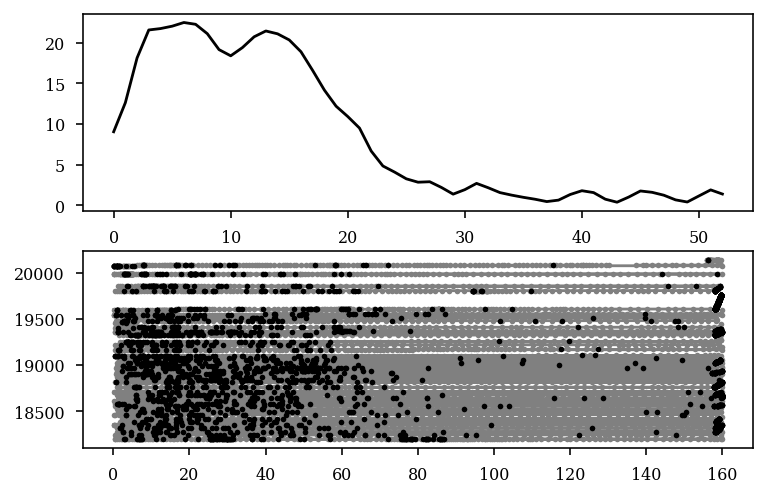

In [238]:
unit_id = 151
fig,ax = plt.subplots(2,1)
ax[0].plot(tc_placecells.ratemap[np.array(tc_placecells.unit_ids) == unit_id].T,color='k')


ax[1].plot(pos.data.T,pos.abscissa_vals,color='grey',marker='.')
_, pos_at_spikes = pos.asarray(at=st[:,unit_id].time)
ax[1].plot(pos_at_spikes,st[:,unit_id].time[0,:], '.k')
# ax.set_aspect('equal')

[  8  29  40  42  44  63  80  83 111 137 142 143 151 188 225 226 234]


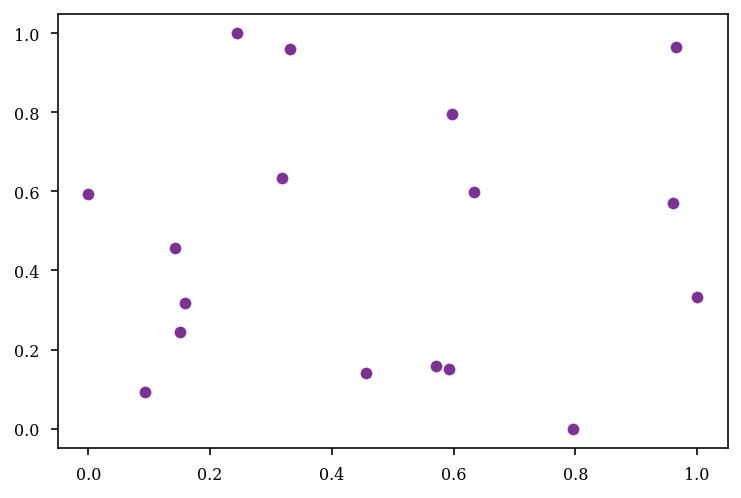

In [253]:
good_idx = st[replay_epochs].n_events > 0
print(np.array(st.series_ids)[good_idx])

place_order = np.array(tc_placecells[good_idx].get_peak_firing_order_ids())
place_order
temporal_order = np.array(st.series_ids)[good_idx][(np.argsort(median_rank_order[good_idx])).astype(int)]
temporal_order

def zero_to_one(x):
    return (x - min(x)) / (max(x) - min(x))
    
plt.scatter(zero_to_one(place_order),zero_to_one(temporal_order))

[225  83 151  80 143 142  40 111   8 226 234  63 137  29  42  44 188 180
 224 139 222 140 216 210 150 205 192 191 152 153 169 174 175 133 177 127
   2 123   5   9  13  18  22  24  27  28  31  37  39 125  41  46  47  59
  70  71  89  96 101 108 112 114  45 236]
[83, 224, 139, 191, 174, 234, 205, 80, 177, 46, 13, 44, 59, 45, 41, 151, 169, 8, 150, 111, 153, 31, 96, 22, 5, 40, 101, 236, 210, 188, 70, 226, 133, 63, 114, 37, 39, 152, 27, 42, 9, 222, 180, 192, 175, 47, 225, 216, 18, 24, 2, 125, 28, 29, 123, 89, 112, 71, 127, 143, 142, 140, 137, 108]


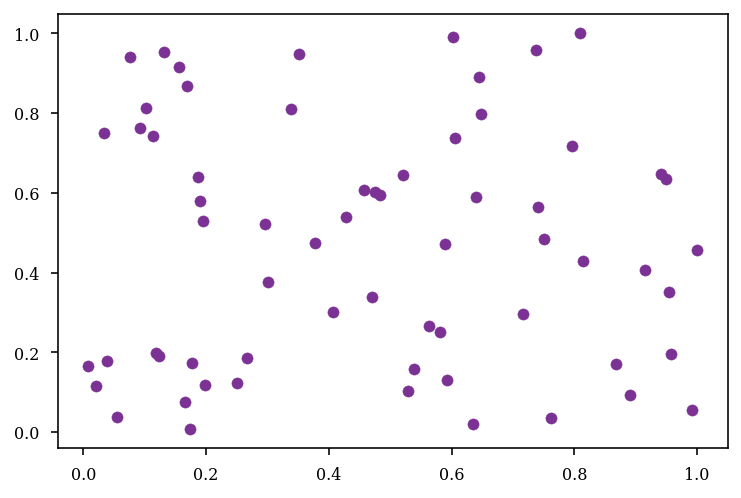

In [250]:
x = np.array(st.series_ids)[(np.argsort(median_rank_order)).astype(int)]
print(x)
no = tc_placecells.get_peak_firing_order_ids()
print(no)

plt.scatter(np.array(x) / max(x),np.array(no)/ max(no))

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


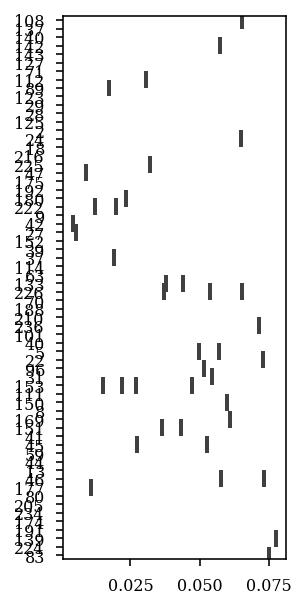

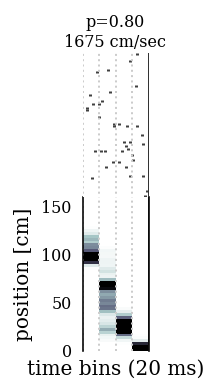

In [118]:
# replays = results['outbound_epochs']['df'][results['outbound_epochs']['df'].score_pval_time_swap < 0.05]

# replay_epochs = nel.EpochArray(np.array([replays.start,replays.stop]).T)

# plt.figure(figsize=(2,5))
# npl.rasterplot(st_cut[replay_epochs[2]],lh=4,lw=4)
# # plt.eventplot(st[replay_epochs][0].data)
# plt.show()
idxs = np.where((results['outbound_epochs']['df']['score_pval_time_swap']<0.05))[0]
idx = idxs[150]
idx = int(idx)


replays = results['outbound_epochs']['df'].iloc[idx]
replay_epochs = nel.EpochArray(np.array([replays.start,replays.stop]).T)

functions.get_rank_order(st,replay_epochs)



no = tc_placecells.get_peak_firing_order_ids()
st.reorder_units_by_ids(no, inplace=True)

st_cut = st[bst[idx].support]
st_cut._support = bst[idx].support # hacky fix so that we can plot events out of order
st_cut = nel.utils.collapse_time(st_cut)

plt.figure(figsize=(2,5))
# npl.rasterplot(st_cut,lh=4,lw=4)
ax = plt.gca()
npl.rasterplot(st_cut, vertstack=True, ax=ax, lh=2,lw=2)


import replay_fig
idxs = np.where((results['outbound_epochs']['df']['score_pval_time_swap']<0.05))[0]
idx = idxs[150]
idx = int(idx)
if isinstance(idx, int):
    title = "p={:.2f}\n{:.0f} cm/sec".format(results['outbound_epochs']['df'].trajectory_score.iloc[idx],
                                                results['outbound_epochs']['df'].traj_speed.iloc[idx])
else:
    title = ""
ax = replay_fig.plot_all_replay(results['outbound_epochs']['bst_placecells'][idx],
                                        results['outbound_epochs']['sta_placecells'],
                                        results['outbound_epochs']['tc'],
                                        results['outbound_epochs']['tc'],
                                        vmax=.1,
                                        title_str=title) 

## make example plots

In [5]:
with open(sessions[0], 'rb') as f:
    results = pickle.load(f)
    
basepath = results['outbound_epochs']['session']

st,cell_metrics = loading.load_spikes(basepath,putativeCellType='Pyr',brainRegion='CA1')

epochs = {
        'forward_outbound_replay': get_replay_epochs(results,'forward','outbound_epochs'),
        'forward_inbound_replay': get_replay_epochs(results,'forward','inbound_epochs'),
        'reverse_outbound_replay': get_replay_epochs(results,'reverse','outbound_epochs'),
        'reverse_inbound_replay': get_replay_epochs(results,'reverse','inbound_epochs')
        }

epoch_df,behavior_epochs = get_pre_linear_post(basepath)

temp_rank_order,rank_order = functions.get_rank_order(st[behavior_epochs[0]],epochs['forward_outbound_replay'])


Text(0.5, 1, 'ripple psth during sorted by rank order for reverse_outbound_replay during linear')

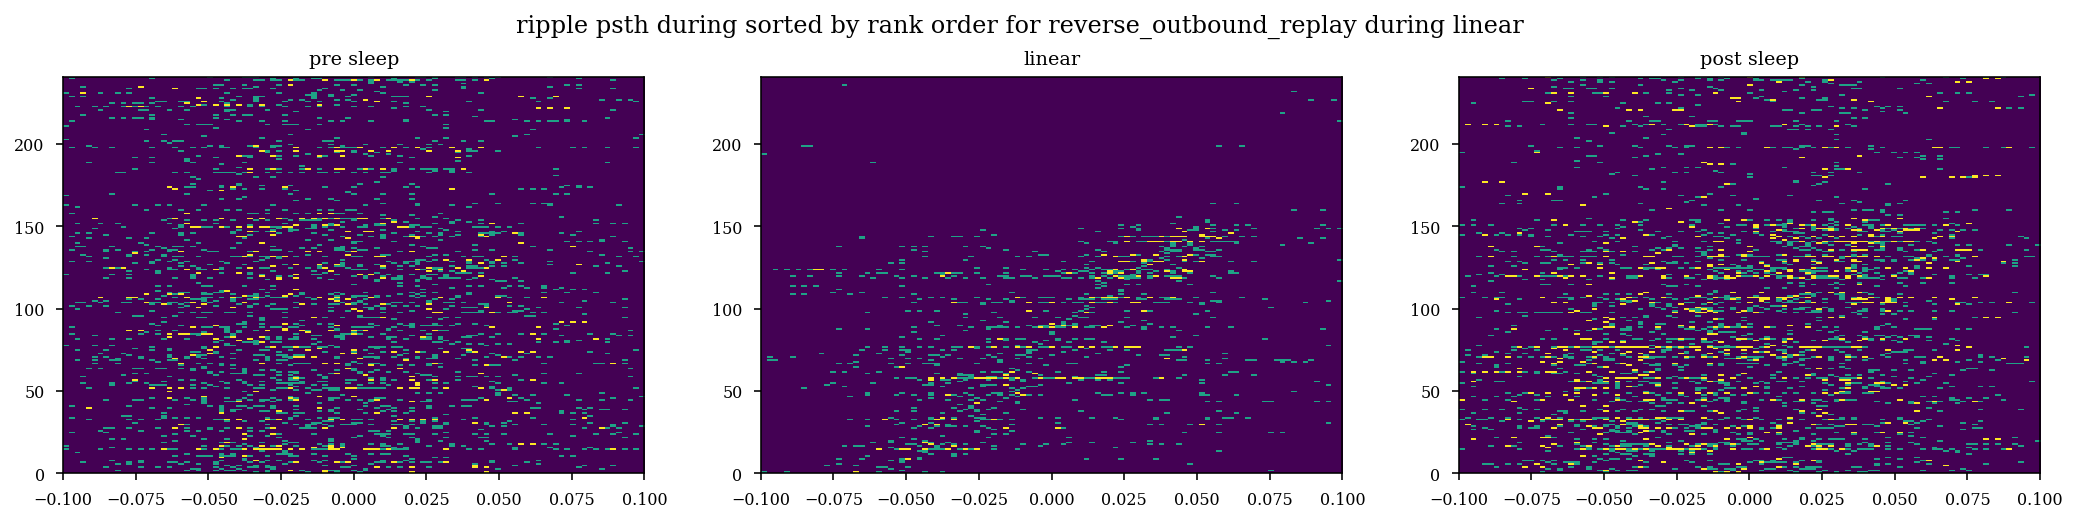

In [6]:
fig, axs = plt.subplots(1,3, figsize=functions.set_size('thesis', fraction=3, subplots=(1,3)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.2)
axs = axs.ravel()

temp_rank_order,rank_order = functions.get_rank_order(st[behavior_epochs[1]],epochs['reverse_outbound_replay'])

ccg = functions.compute_psth(st[behavior_epochs[0]].data,epochs['reverse_outbound_replay'].centers)
extent = [ccg.index.min(),ccg.index.max(),0,ccg.shape[1]]
axs[0].imshow(ccg[np.argsort(temp_rank_order)].T,aspect='auto',interpolation='nearest',origin='lower',vmax=10,extent=extent)

ccg = functions.compute_psth(st[behavior_epochs[1]].data,epochs['reverse_outbound_replay'].centers)
extent = [ccg.index.min(),ccg.index.max(),0,ccg.shape[1]]
axs[1].imshow(ccg[np.argsort(temp_rank_order)].T,aspect='auto',interpolation='nearest',origin='lower',vmax=10,extent=extent)

ccg = functions.compute_psth(st[behavior_epochs[2]].data,epochs['reverse_outbound_replay'].centers)
extent = [ccg.index.min(),ccg.index.max(),0,ccg.shape[1]]
axs[2].imshow(ccg[np.argsort(temp_rank_order)].T,aspect='auto',interpolation='nearest',origin='lower',vmax=10,extent=extent)

axs[0].set_title('pre sleep')
axs[1].set_title('linear')
axs[2].set_title('post sleep')

fig.suptitle('ripple psth during sorted by rank order for reverse_outbound_replay during linear', y=1,fontsize=12)

Text(0.5, 1, 'ripple psth during linear track sorted by rank order for reverse_outbound_replay')

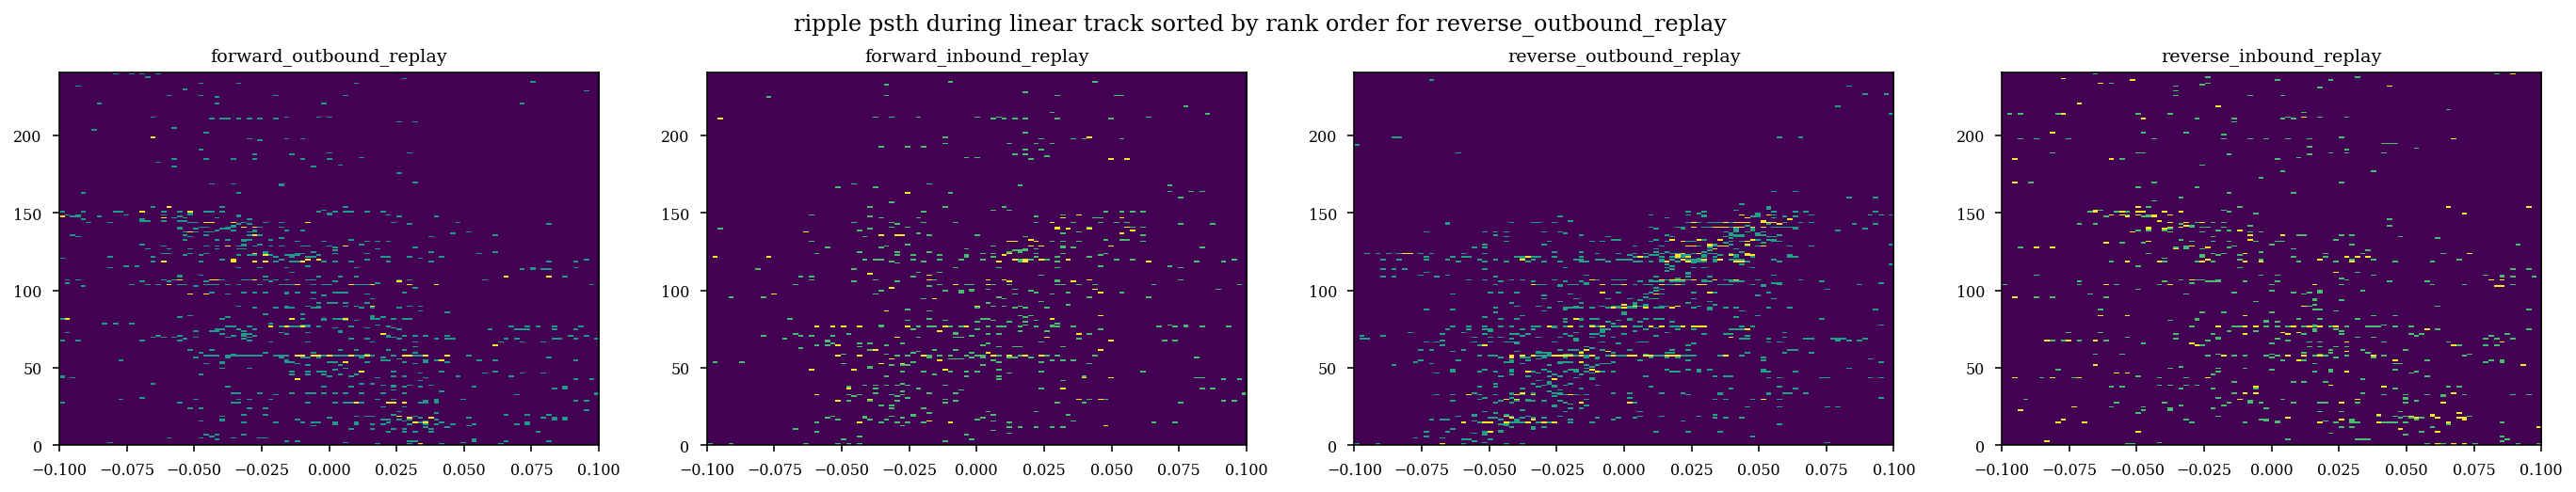

In [10]:
fig, axs = plt.subplots(1,4, figsize=functions.set_size('thesis', fraction=4, subplots=(1,4)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.2)
axs = axs.ravel()

temp_rank_order,rank_order = functions.get_rank_order(st[behavior_epochs[1]],epochs['reverse_outbound_replay'])

ccg = functions.compute_psth(st[behavior_epochs[1]].data,epochs['forward_outbound_replay'].centers)
extent = [ccg.index.min(),ccg.index.max(),0,ccg.shape[1]]
axs[0].imshow(ccg[np.argsort(temp_rank_order)].T,aspect='auto',interpolation='nearest',origin='lower',vmax=10,extent=extent)

ccg = functions.compute_psth(st[behavior_epochs[1]].data,epochs['forward_inbound_replay'].centers)
extent = [ccg.index.min(),ccg.index.max(),0,ccg.shape[1]]
axs[1].imshow(ccg[np.argsort(temp_rank_order)].T,aspect='auto',interpolation='nearest',origin='lower',vmax=10,extent=extent)

ccg = functions.compute_psth(st[behavior_epochs[1]].data,epochs['reverse_outbound_replay'].centers)
extent = [ccg.index.min(),ccg.index.max(),0,ccg.shape[1]]
axs[2].imshow(ccg[np.argsort(temp_rank_order)].T,aspect='auto',interpolation='nearest',origin='lower',vmax=10,extent=extent)

ccg = functions.compute_psth(st[behavior_epochs[1]].data,epochs['reverse_inbound_replay'].centers)
extent = [ccg.index.min(),ccg.index.max(),0,ccg.shape[1]]
axs[3].imshow(ccg[np.argsort(temp_rank_order)].T,aspect='auto',interpolation='nearest',origin='lower',vmax=10,extent=extent)

axs[0].set_title('forward_outbound_replay')
axs[1].set_title('forward_inbound_replay')
axs[2].set_title('reverse_outbound_replay')
axs[3].set_title('reverse_inbound_replay')

fig.suptitle('ripple psth during linear track sorted by rank order for reverse_outbound_replay', y=1,fontsize=12)


In [11]:
epochs

{'forward_outbound_replay': <EpochArray at 0x1de63615130: 93 epochs> of length 9.4824 seconds,
 'forward_inbound_replay': <EpochArray at 0x1de3c734490: 71 epochs> of length 7.156 seconds,
 'reverse_outbound_replay': <EpochArray at 0x1deb0430970: 87 epochs> of length 9.028 seconds,
 'reverse_inbound_replay': <EpochArray at 0x1de40d29af0: 71 epochs> of length 7.2576 seconds}

Text(0.5, 0.98, 'reverse')

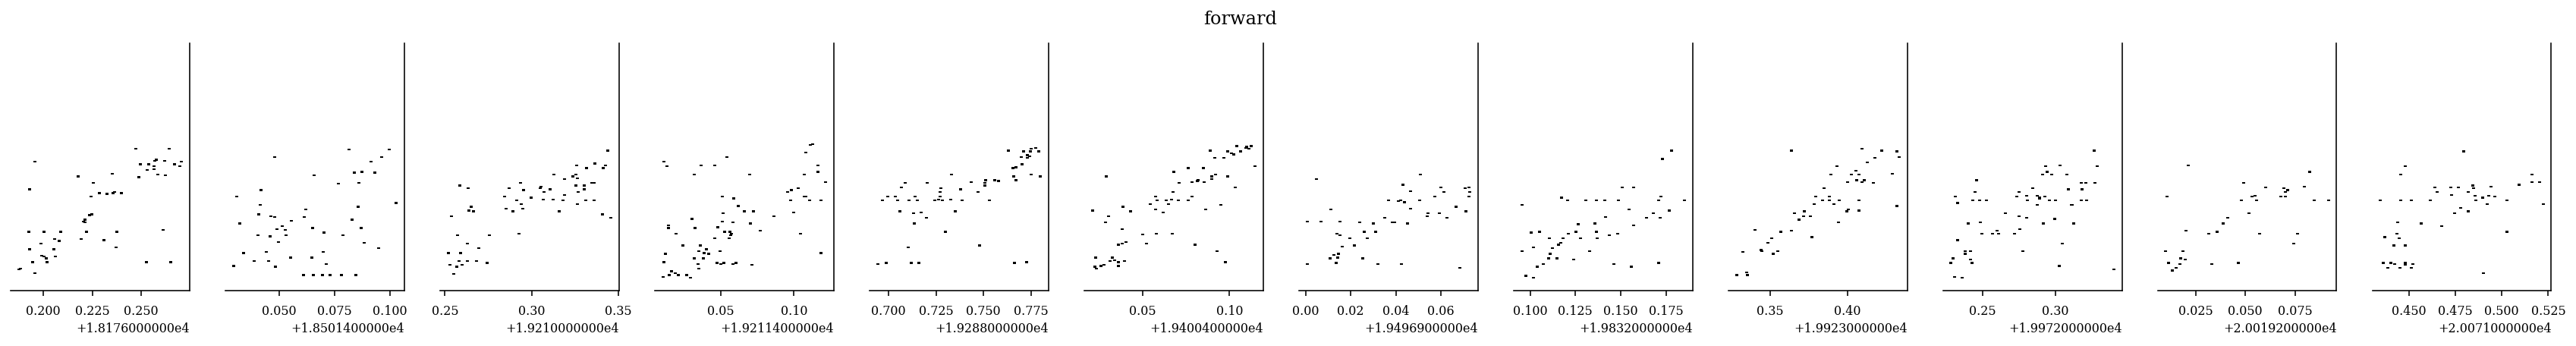

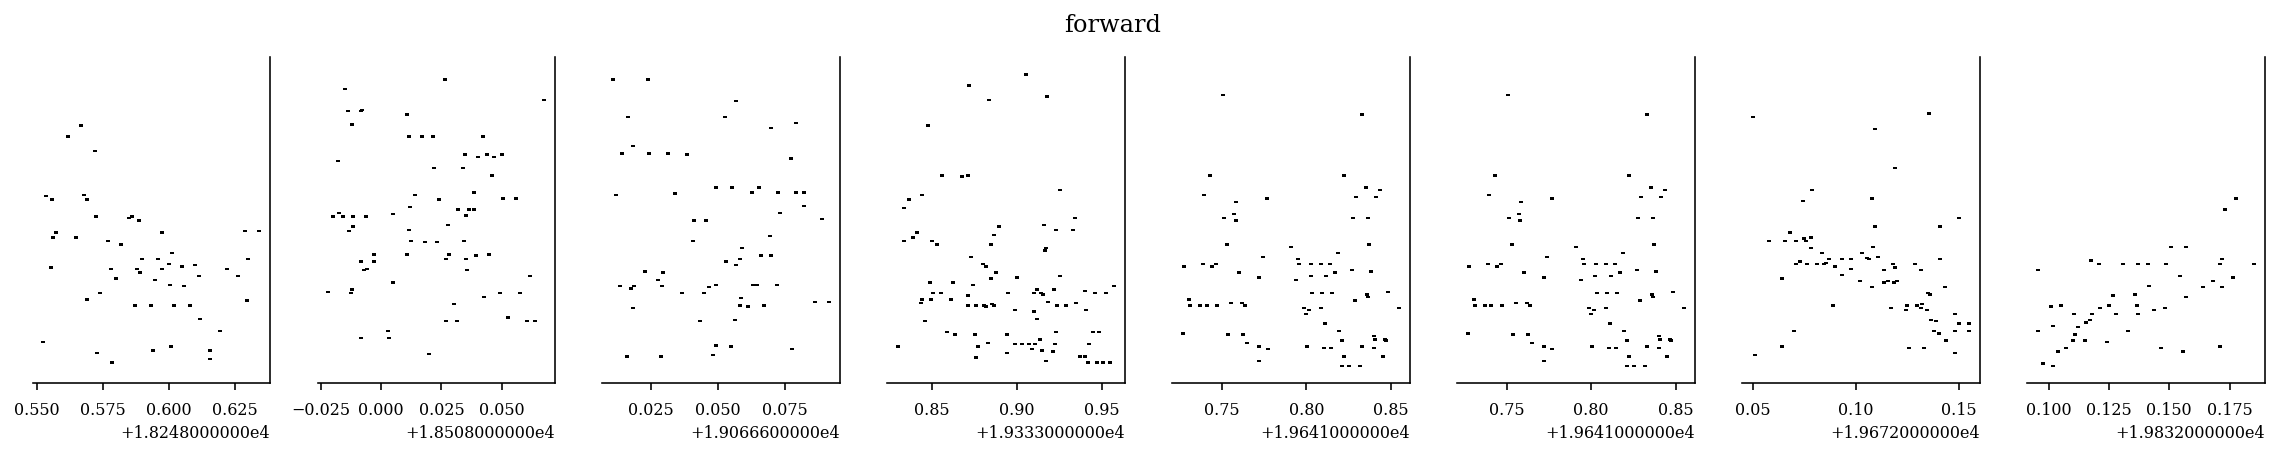

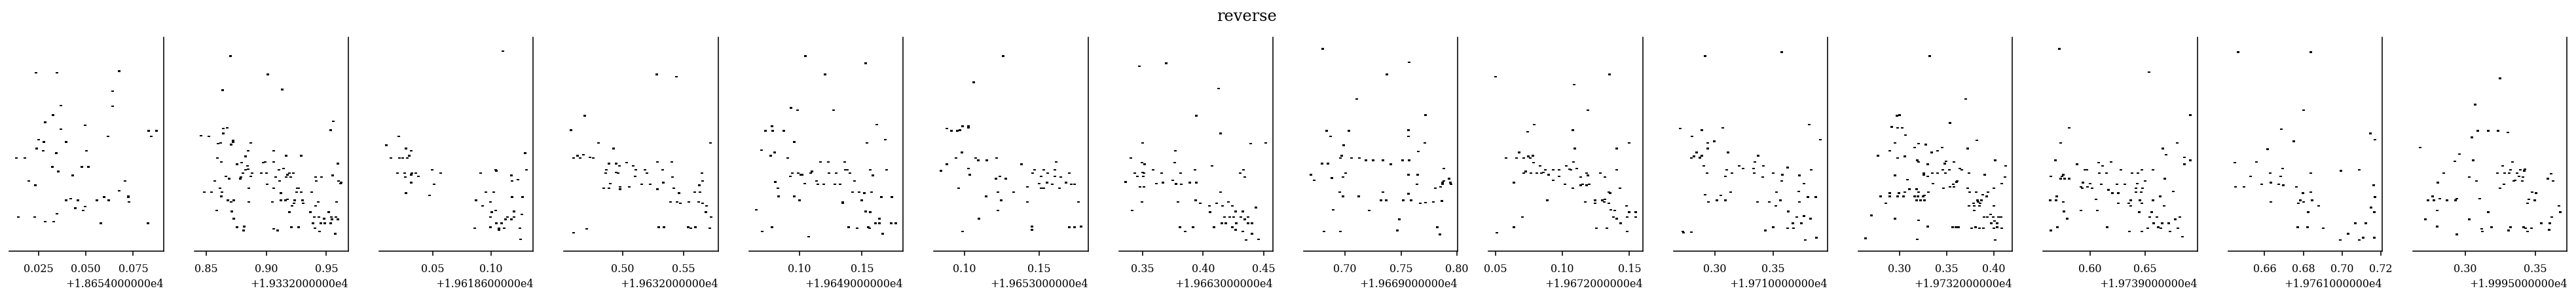

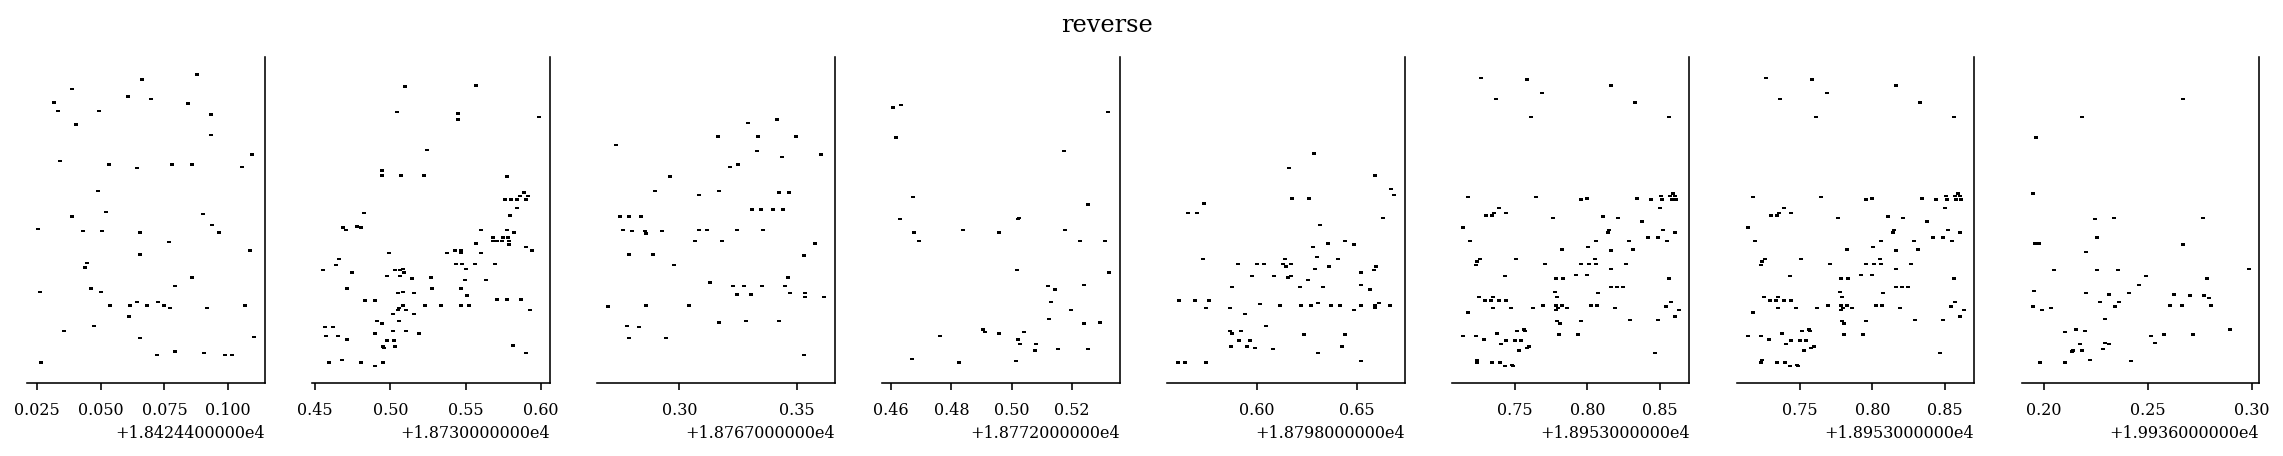

In [12]:
def plot_rasters(st,behavior_epochs,epochs,temp_rank_order,behavior_epochs_n=0,epoch_label='forward_outbound_replay'):

    
    n_intervals = st[behavior_epochs[behavior_epochs_n]][epochs[epoch_label]].n_intervals

    fig,ax = plt.subplots(1,n_intervals,figsize=(25*n_intervals*.1,3))

    for rip in range(n_intervals):
        try:
            ax[rip].eventplot(st[behavior_epochs[behavior_epochs_n]][epochs[epoch_label]][rip].data[np.argsort(temp_rank_order)],
                                linewidths=2,linelengths=2,color='k')
        except:
            pass
        ax[rip].spines["top"].set_visible(False)
        ax[rip].spines["left"].set_visible(False)
        ax[rip].get_yaxis().set_visible(False)

temp_rank_order,rank_order = functions.get_rank_order(st[behavior_epochs[1]],epochs['forward_outbound_replay'])

plot_rasters(st,behavior_epochs,epochs,temp_rank_order,behavior_epochs_n=[1],epoch_label='forward_outbound_replay')
plt.gcf().suptitle('forward')
plot_rasters(st,behavior_epochs,epochs,temp_rank_order,behavior_epochs_n=1,epoch_label='forward_inbound_replay')
plt.gcf().suptitle('forward')
plot_rasters(st,behavior_epochs,epochs,temp_rank_order,behavior_epochs_n=1,epoch_label='reverse_outbound_replay')
plt.gcf().suptitle('reverse')
plot_rasters(st,behavior_epochs,epochs,temp_rank_order,behavior_epochs_n=1,epoch_label='reverse_inbound_replay')
plt.gcf().suptitle('reverse')


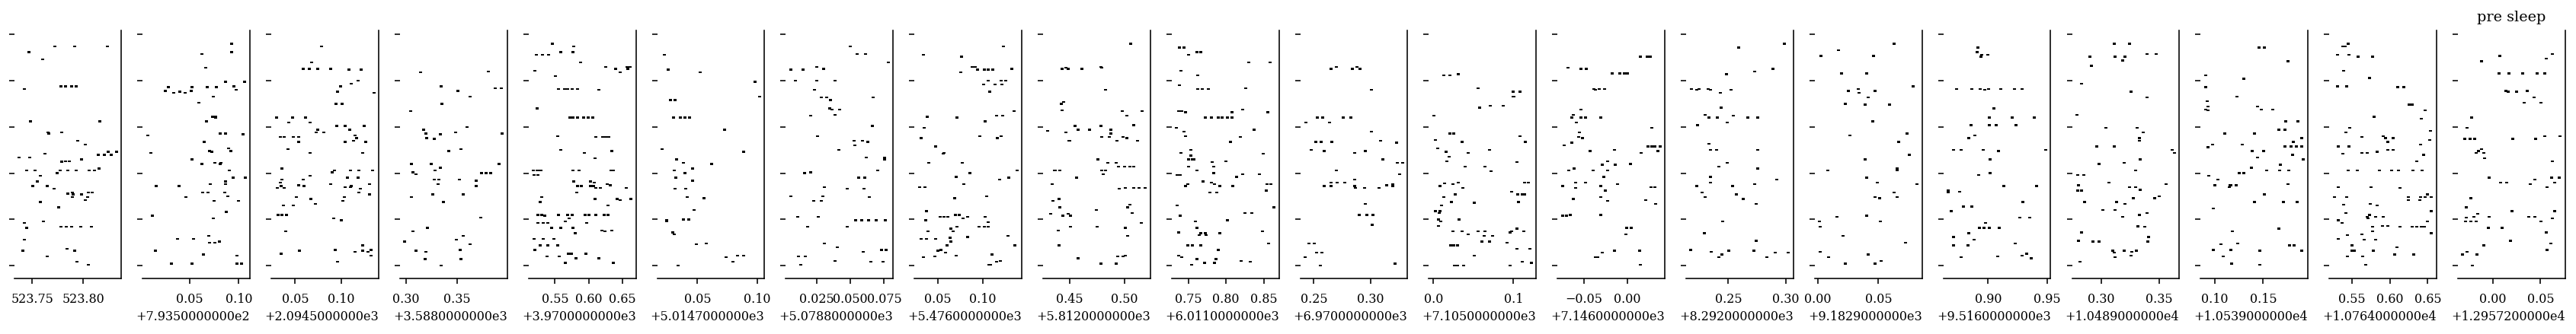

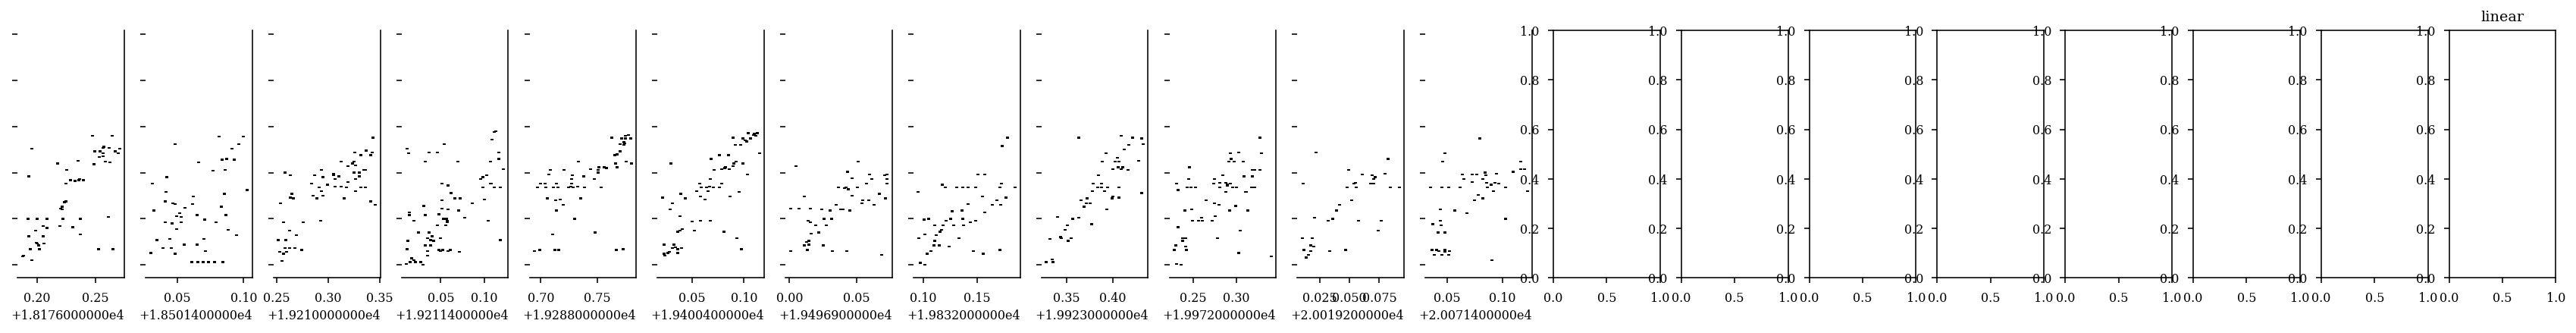

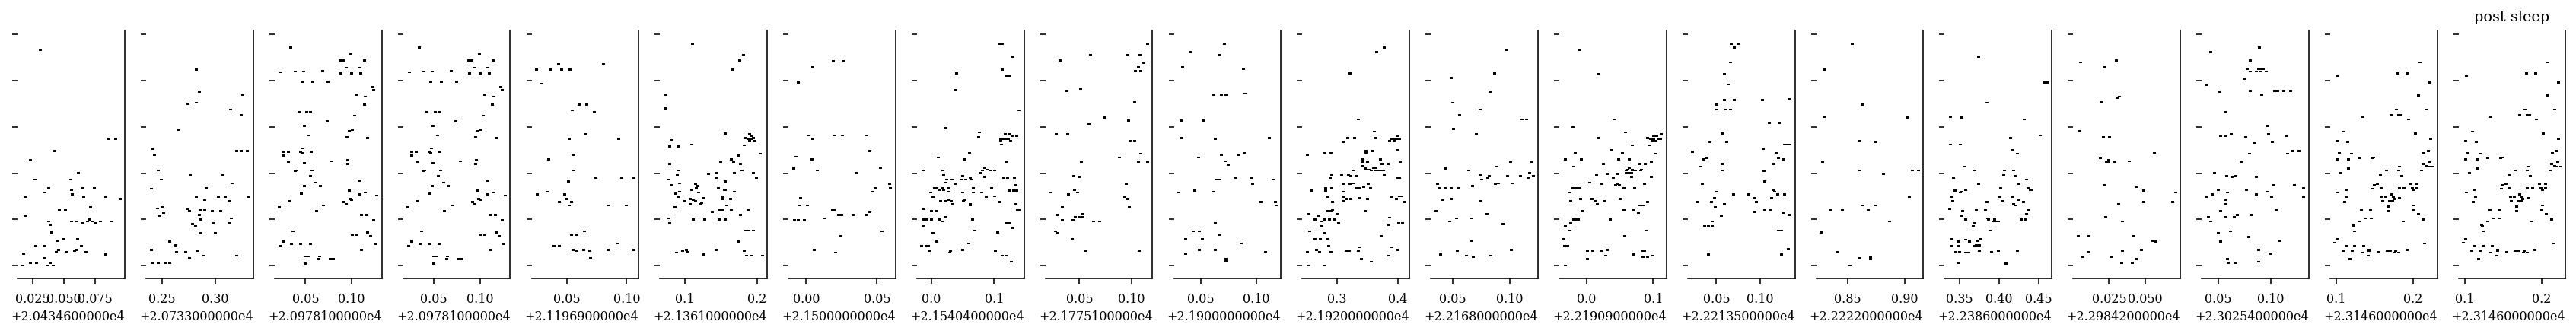

In [14]:
temp_rank_order,rank_order = functions.get_rank_order(st[behavior_epochs[1]],epochs['forward_outbound_replay'])

fig,ax = plt.subplots(1,20,figsize=(30,3))
for rip in range(st[behavior_epochs[0]][epochs['forward_outbound_replay']].n_intervals):
    if rip >= 20:
        break
    try:
        ax[rip].eventplot(st[behavior_epochs[0]][epochs['forward_outbound_replay']][rip].data[np.argsort(temp_rank_order)],linewidths=2,linelengths=2,color='k')
    except:
        pass
    ax[rip].spines["top"].set_visible(False)
    ax[rip].spines["left"].set_visible(False)
    ax[rip].set_yticklabels('')
plt.title('pre sleep')    
plt.show()

fig,ax = plt.subplots(1,20,figsize=(30,3))
# temp_rank_order,rank_order = functions.get_rank_order(st[behavior_epochs[1]],epochs['forward_outbound_replay'])
for rip in range(st[behavior_epochs[1]][epochs['forward_outbound_replay']].n_intervals):
    if rip >= 20:
        break
    try:
        ax[rip].eventplot(st[behavior_epochs[1]][epochs['forward_outbound_replay']][rip].data[np.argsort(temp_rank_order)],linewidths=2,linelengths=2,color='k')
    except:
        pass
    ax[rip].spines["top"].set_visible(False)
    ax[rip].spines["left"].set_visible(False)
    ax[rip].set_yticklabels('')
plt.title('linear')    
plt.show()

fig,ax = plt.subplots(1,20,figsize=(30,3))
# temp_rank_order,rank_order = functions.get_rank_order(st[behavior_epochs[2]],epochs['forward_outbound_replay'])
for rip in range(st[behavior_epochs[2]][epochs['forward_outbound_replay']].n_intervals):
    if rip >= 20:
        break
    try:
        ax[rip].eventplot(st[behavior_epochs[2]][epochs['forward_outbound_replay']][rip].data[np.argsort(temp_rank_order)],linewidths=2,linelengths=2,color='k')
    except:
        pass
    ax[rip].spines["top"].set_visible(False)
    ax[rip].spines["left"].set_visible(False)
    ax[rip].set_yticklabels('')
plt.title('post sleep')    
plt.show()

## Test out rank order 

In [457]:
basepath = r'Z:\Data\GrosmarkAD\Achilles\Achilles_10252013'
# st,cell_metrics = loading.load_spikes(basepath,brainRegion='CA1',putativeCellType='Pyramidal')
st,cell_metrics = loading.load_spikes(basepath,brainRegion='CA1')

ripples = loading.load_ripples_events(basepath)
ripple_epochs = nel.EpochArray(np.array([ripples.start,ripples.stop]).T)

epoch_df = loading.load_epoch(basepath)
epoch_df_epochs = nel.EpochArray(np.array([epoch_df.startTime,epoch_df.stopTime]).T)


In [458]:
importlib.reload(functions)
median_rank_order,rank_order = functions.get_rank_order(st,ripple_epochs[epoch_df_epochs[1]],method='peak_fr')


In [459]:
median_rank_order_test,rank_order_test = functions.get_rank_order(st,ripple_epochs[epoch_df_epochs[1]],method='first_spike')


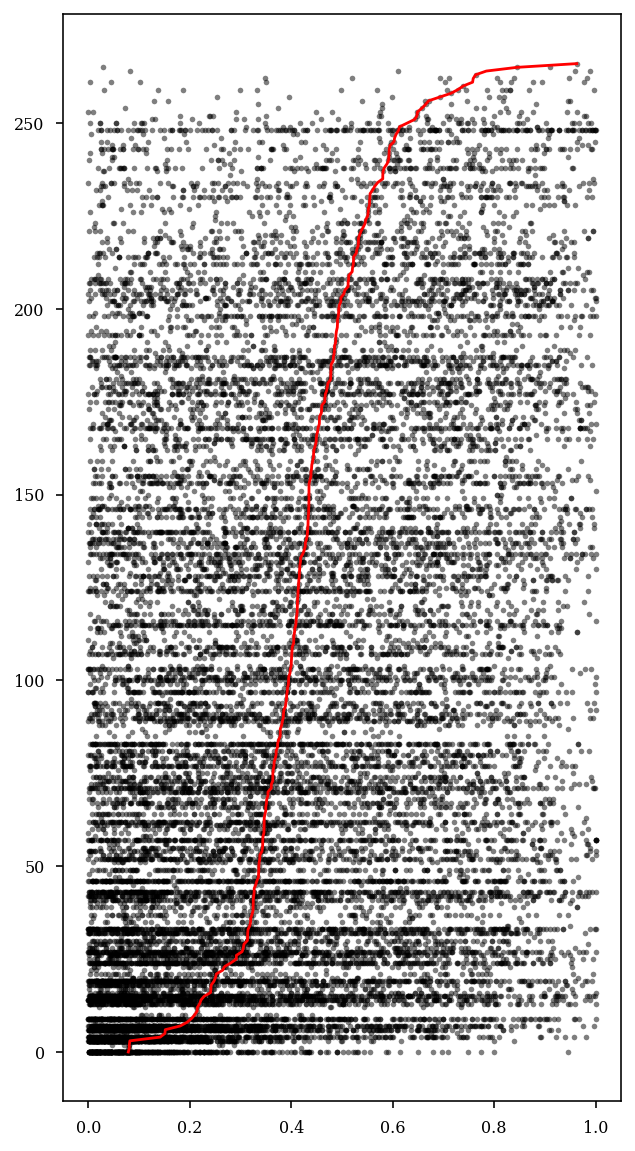

In [460]:
plt.figure(figsize=(5,10))
idx = np.argsort(median_rank_order_test)
# avg_fr = st.n_spikes / (st.last_event - st.first_event)
# idx = np.argsort(avg_fr)

plt.plot(rank_order_test[idx],np.arange(rank_order_test.shape[0]),'.k',alpha=.5)
plt.plot(median_rank_order_test[idx],np.arange(median_rank_order_test.shape[0]),'r')
plt.show()

In [464]:
avg_fr = st.n_spikes / (st.last_event - st.first_event)
# avg_fr

Text(0, 0.5, 'units')

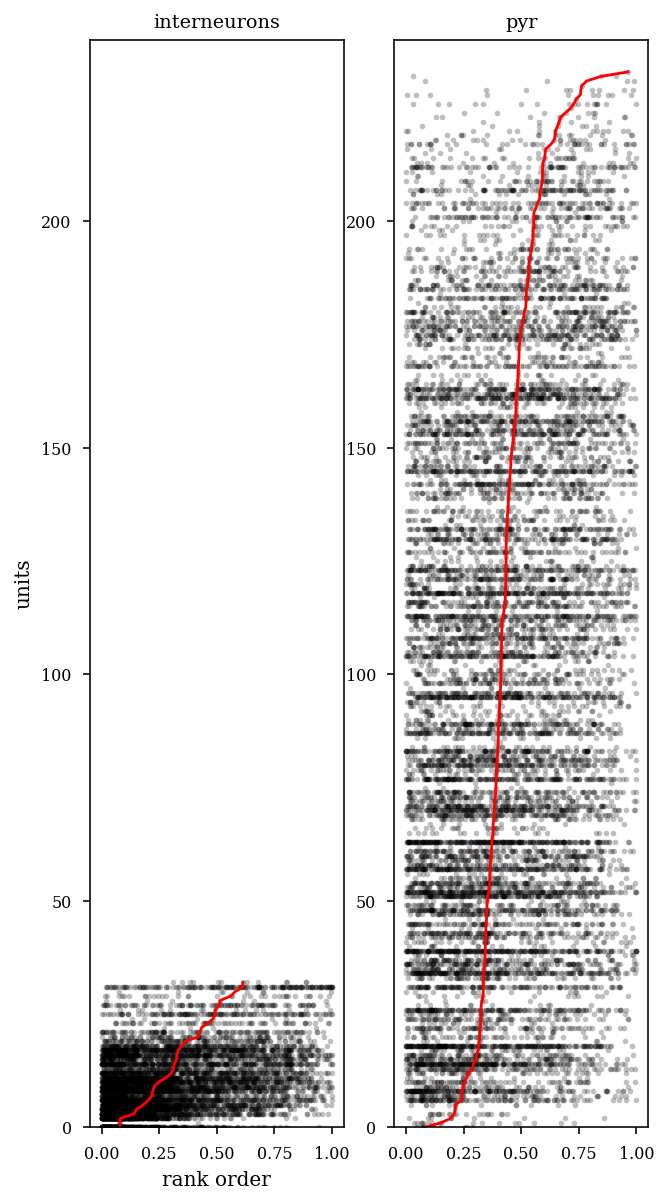

In [497]:
fig,ax = plt.subplots(1,2,figsize=(5,10))

interneuron_idx = cell_metrics.putativeCellType.str.contains('Interneuron')
idx = np.argsort(median_rank_order_test[interneuron_idx])
ax[0].plot(rank_order_test[interneuron_idx][idx],np.arange(rank_order_test[interneuron_idx].shape[0]),'.k',alpha=.25)
ax[0].plot(median_rank_order_test[interneuron_idx][idx],np.arange(median_rank_order_test[interneuron_idx].shape[0]),'r')

pyr_idx = cell_metrics.putativeCellType.str.contains('Pyramidal')
idx = np.argsort(median_rank_order_test[pyr_idx])
ax[1].plot(rank_order_test[pyr_idx][idx],np.arange(rank_order_test[pyr_idx].shape[0]),'.k',alpha=.25)
ax[1].plot(median_rank_order_test[pyr_idx][idx],np.arange(median_rank_order_test[pyr_idx].shape[0]),'r')

ax[0].set_ylim(0,240)
ax[1].set_ylim(0,240)

ax[0].set_title('interneurons')
ax[1].set_title('pyr')


ax[0].set_xlabel('rank order')
ax[0].set_ylabel('units')




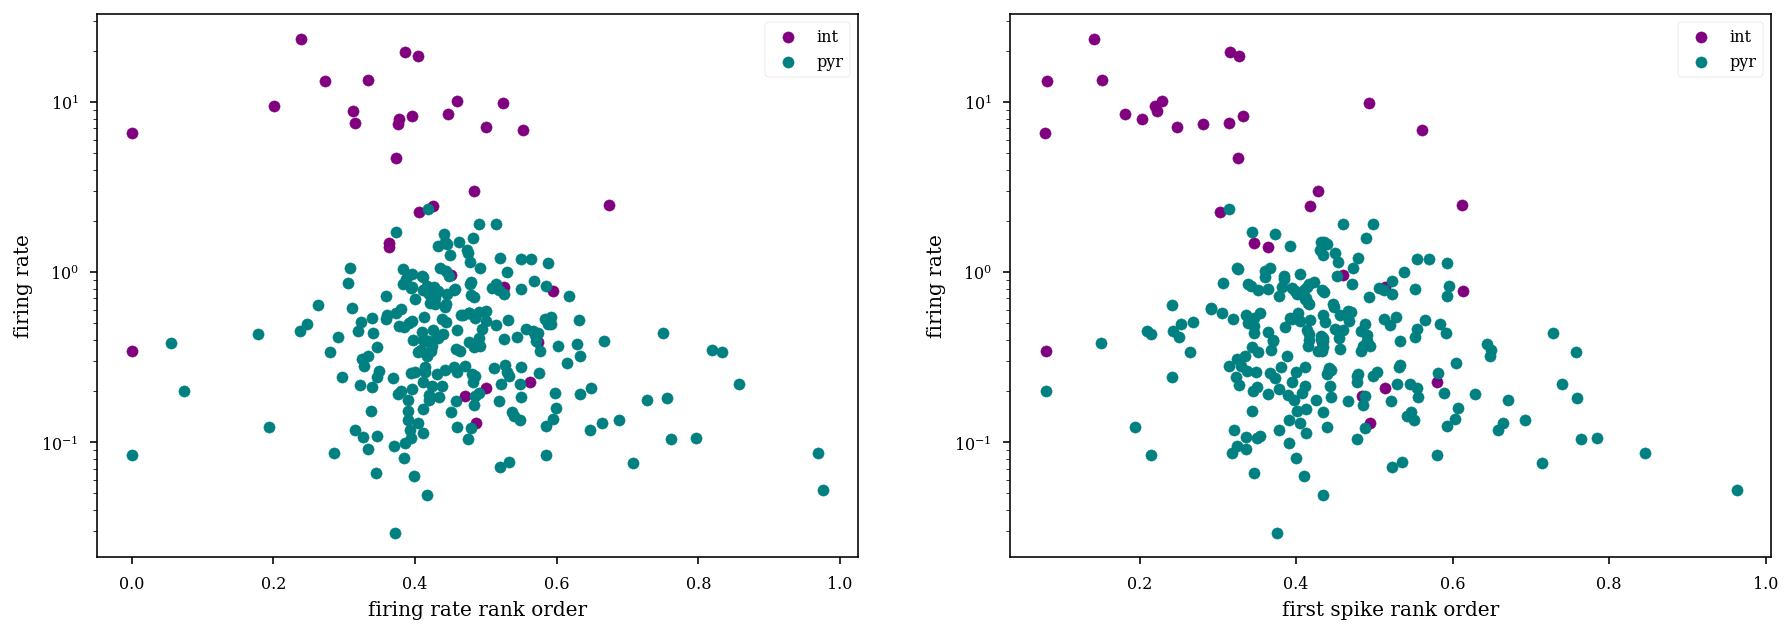

In [486]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

interneuron_idx = cell_metrics.putativeCellType.str.contains('Interneuron')
ax[0].scatter(median_rank_order[interneuron_idx],avg_fr[interneuron_idx],color='purple',label='int')

pyr_idx = cell_metrics.putativeCellType.str.contains('Pyramidal')
ax[0].scatter(median_rank_order[pyr_idx],avg_fr[pyr_idx],color='teal',label='pyr')
ax[0].set_yscale('log')
ax[0].set_xlabel('firing rate rank order')
ax[0].set_ylabel('firing rate')
ax[0].legend()

interneuron_idx = cell_metrics.putativeCellType.str.contains('Interneuron')
ax[1].scatter(median_rank_order_test[interneuron_idx],avg_fr[interneuron_idx],color='purple',label='int')

pyr_idx = cell_metrics.putativeCellType.str.contains('Pyramidal')
ax[1].scatter(median_rank_order_test[pyr_idx],avg_fr[pyr_idx],color='teal',label='pyr')
ax[1].set_yscale('log')
ax[1].set_xlabel('first spike rank order')
ax[1].set_ylabel('firing rate')
ax[1].legend()


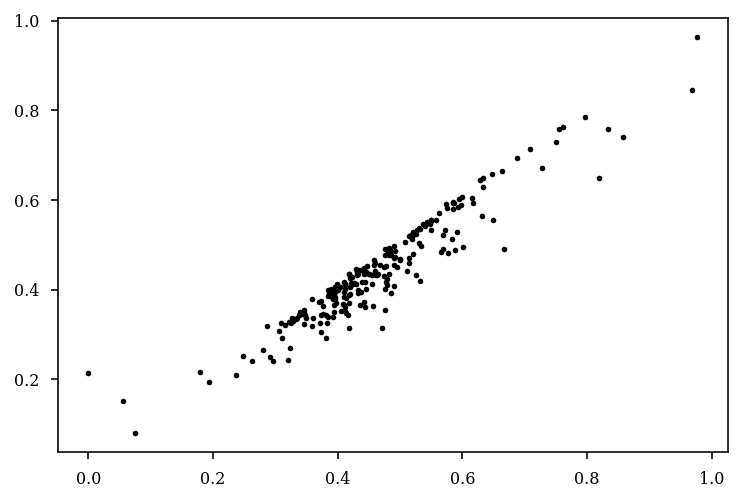

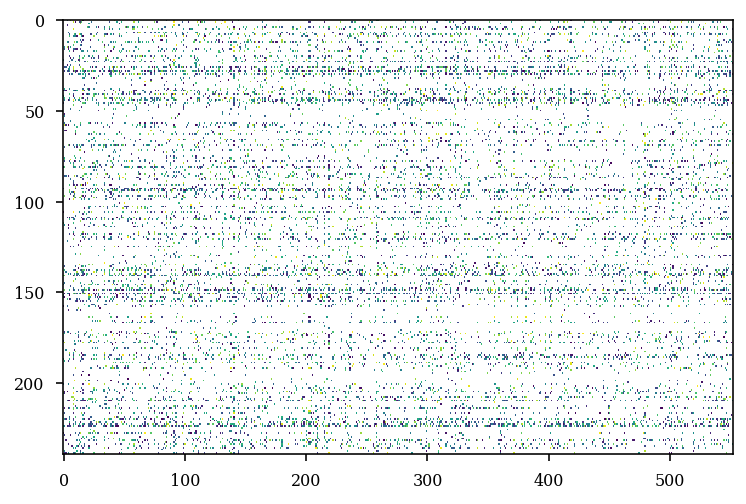

In [397]:
plt.plot(median_rank_order,median_rank_order_test,'.k')
plt.figure()
plt.imshow(rank_order_test,aspect='auto',interpolation='nearest')


In [15]:
# df_rank_order.aggregate(['basepath','UID'])
# df_rank_order[(df_rank_order.basepath == 'Z:\Data\AYAold\AYA4\day150804') & (df_rank_order.environment == 0) & (df_rank_order.label == 'forward_outbound_replay') ]
# plt.figure()
pre_post_change = []
pre_task_change = []
for basepath in df_rank_order.basepath.unique():
    for label in df_rank_order[(df_rank_order.basepath == basepath) & (df_rank_order.label == 'forward_outbound_replay')].label.unique():
        for UID in df_rank_order[(df_rank_order.basepath == basepath) & (df_rank_order.label == label) & (df_rank_order.label == 'forward_outbound_replay') ].UID.unique():
            median_rank_order = df_rank_order[
                                            (df_rank_order.basepath == basepath) &
                                            (df_rank_order.label == label) &
                                            (df_rank_order.label == 'forward_outbound_replay') &
                                            (df_rank_order.UID == UID)
                                            ].median_rank_order.values
            pre_task_change.append(median_rank_order[1] - median_rank_order[0]) 
            pre_post_change.append(median_rank_order[-1] - median_rank_order[0])                              

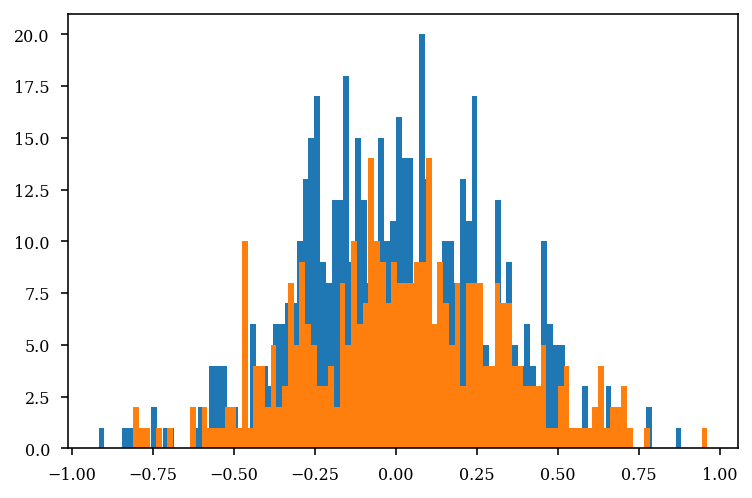

In [16]:
plt.hist(pre_post_change,100)
plt.hist(pre_task_change,100)
plt.show()


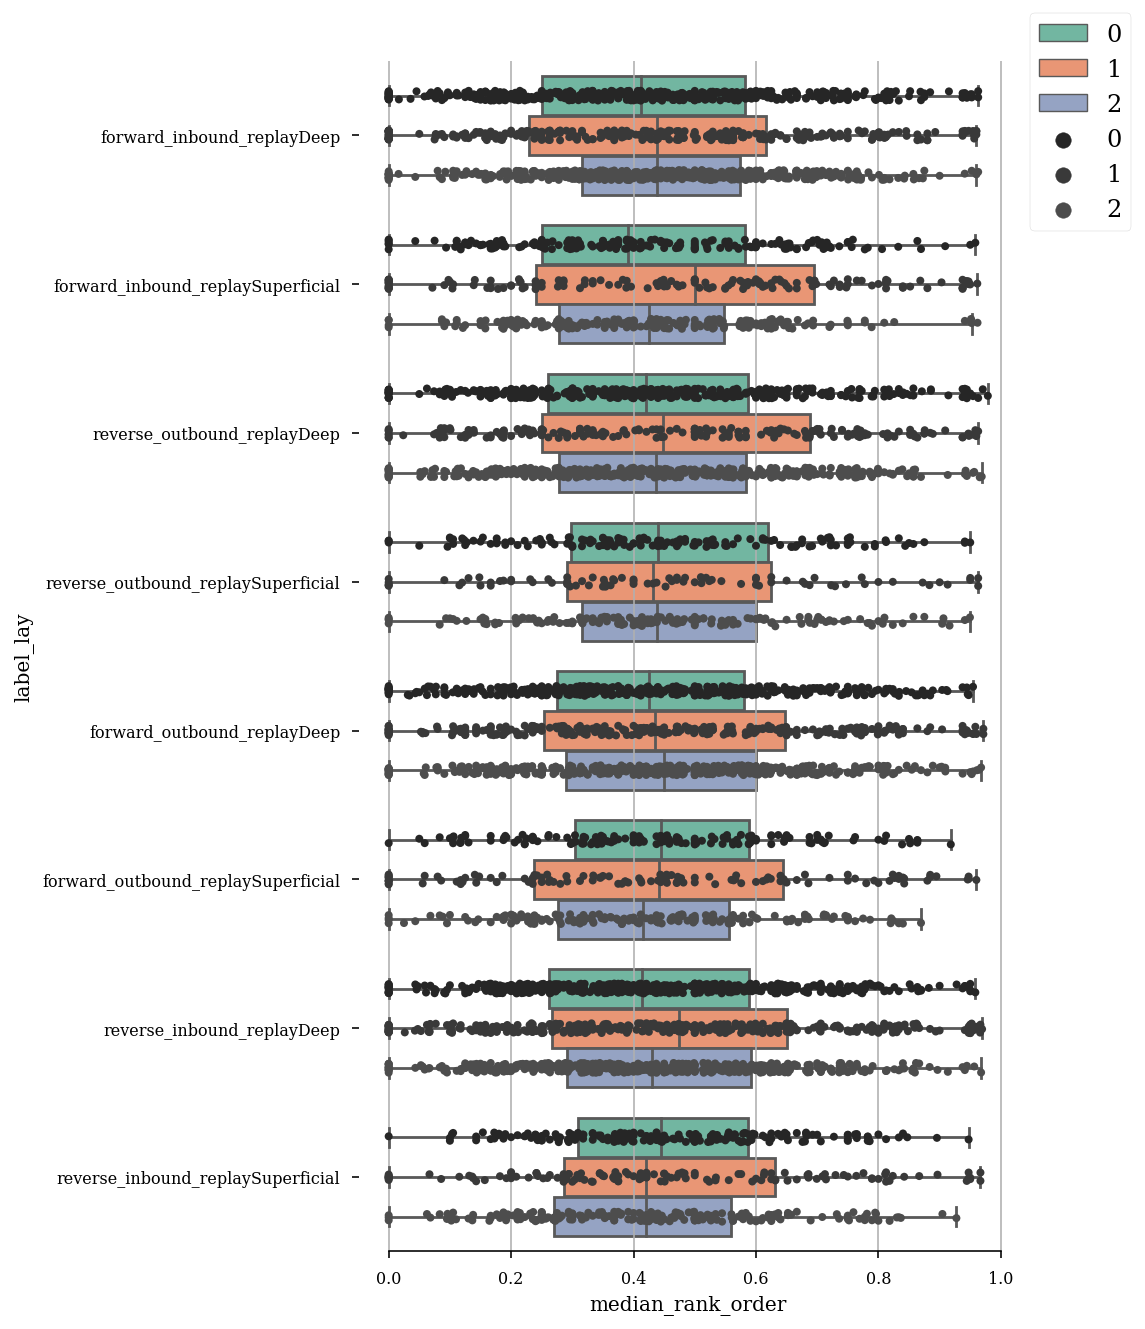

In [17]:
plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(3,1)), edgecolor=None)
ax = plt.gca()
# hue_order = ['forward_inbound_replay','reverse_outbound_replay','forward_outbound_replay','reverse_inbound_replay']

hue_order = ['forward_inbound_replayDeep','forward_inbound_replaySuperficial',
            'reverse_outbound_replayDeep','reverse_outbound_replaySuperficial',
            'forward_outbound_replayDeep','forward_outbound_replaySuperficial',
            'reverse_inbound_replayDeep','reverse_inbound_replaySuperficial']
# import matplotlib
# cmap = matplotlib.cm.get_cmap('Set2',8)
sns.set_palette(sns.color_palette('Set2',8))
sns.boxplot(data=df_rank_order,x="median_rank_order", y="label_lay",order=hue_order,hue='environment',
            ax=ax,showfliers=False)

sns.stripplot(data=df_rank_order,x="median_rank_order", y="label_lay",order=hue_order,hue='environment',
            size=4, color=".3", linewidth=0,dodge=True,ax=ax)

# sns.stripplot(x="median_rank_order", y="environment", data=df_rank_order,hue="label_lay",hue_order=hue_order,
#                 size=4, color=".3", linewidth=0,dodge=True,ax=ax)
ax.legend(bbox_to_anchor=(1, 1.05),fontsize=12)
# plt.axhline(.5,linestyle='--')
# ax = plt.gca()
ax.xaxis.grid(True)
sns.despine(trim=True, left=True)

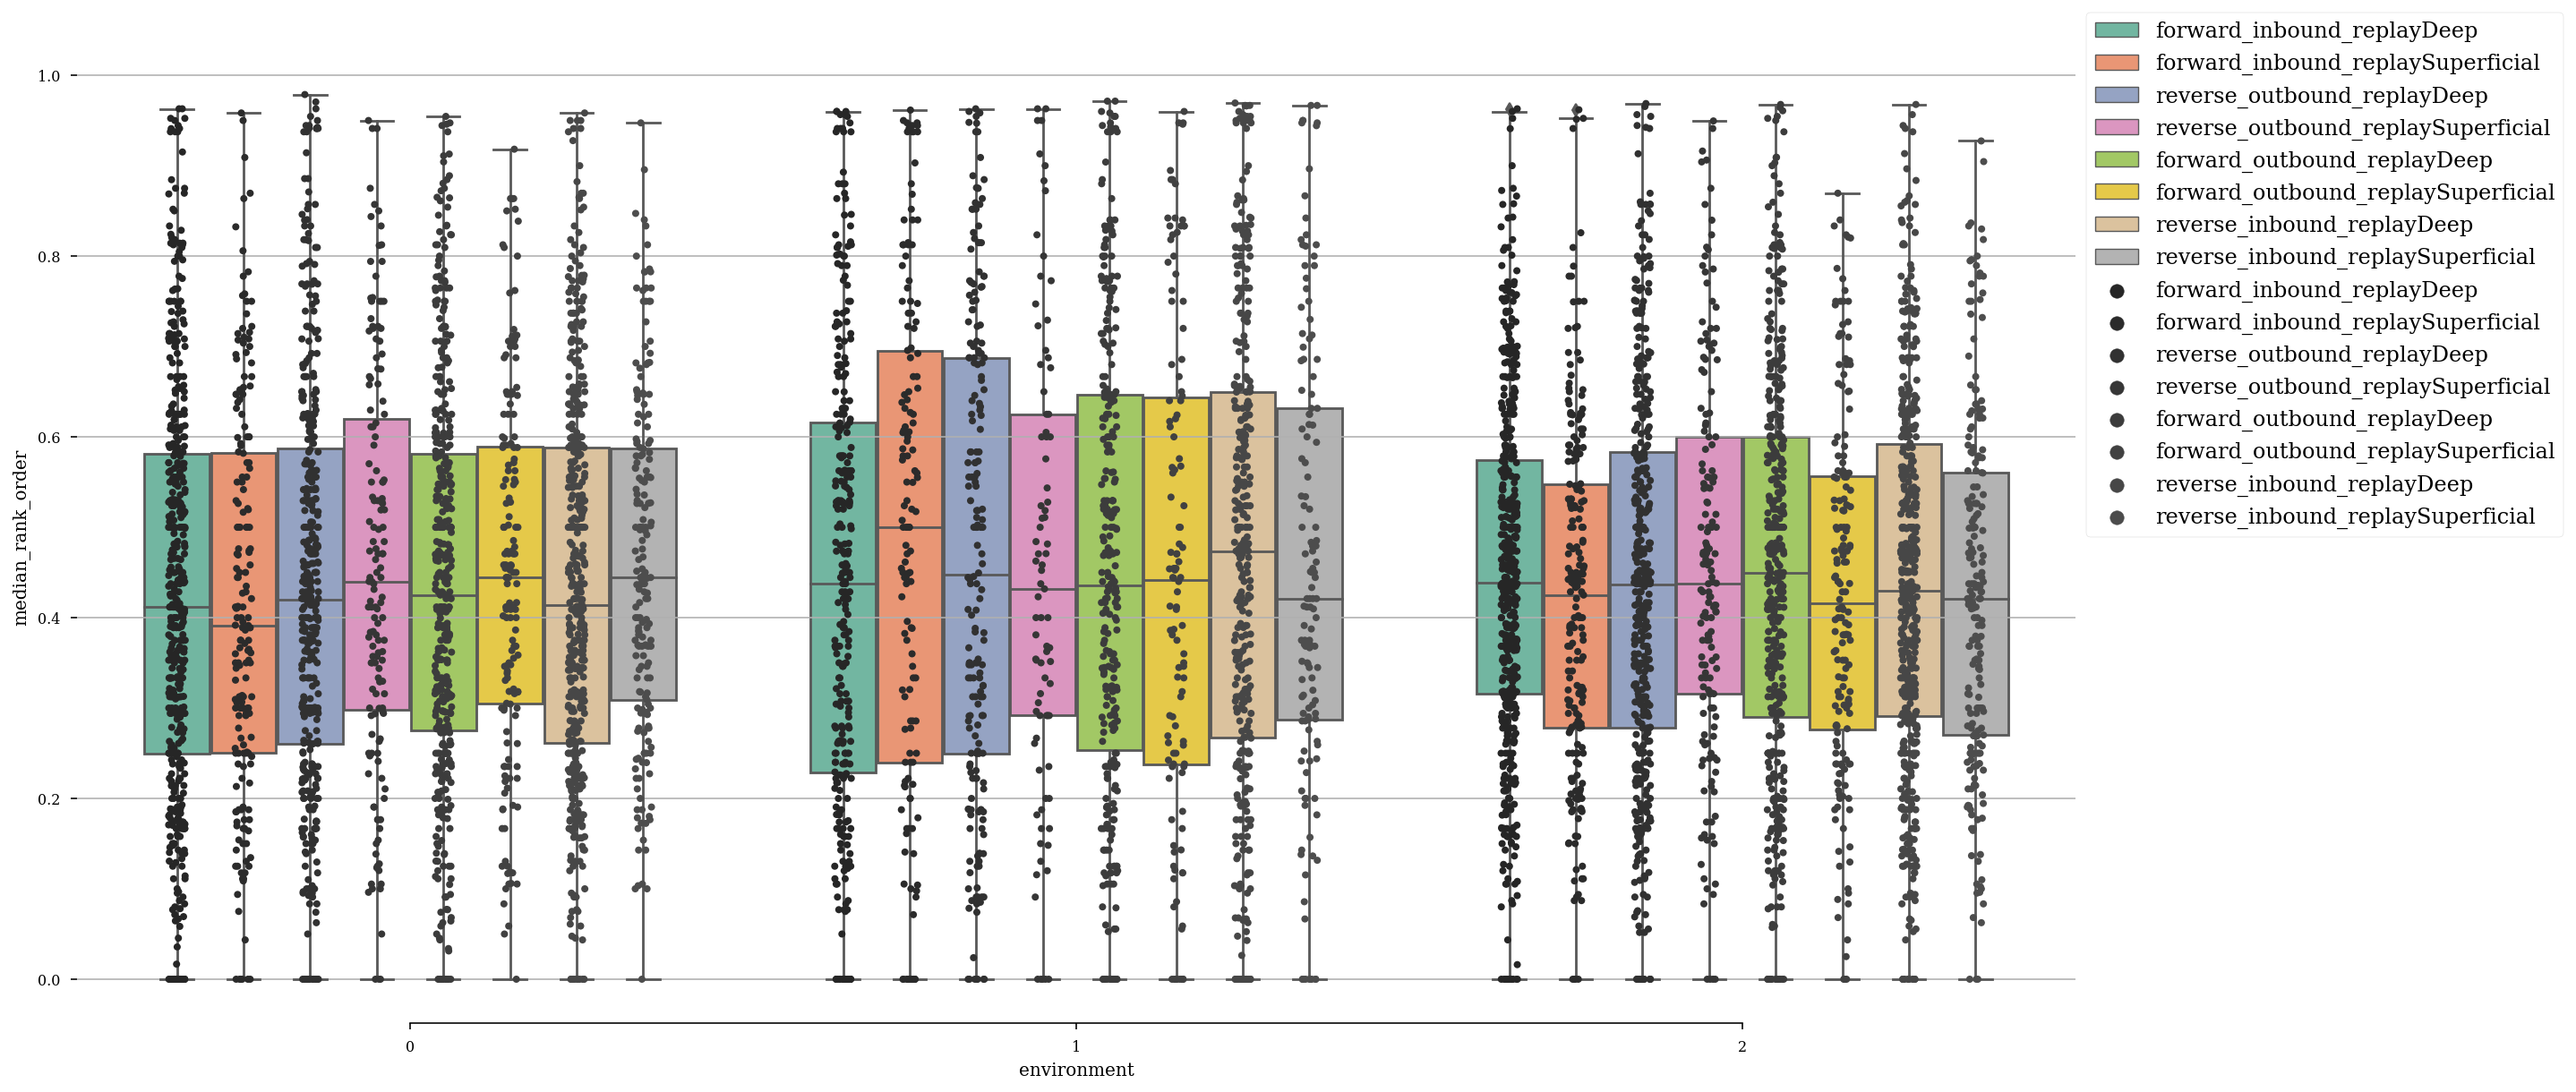

In [18]:
f, ax = plt.subplots(figsize=(20,10))

# hue_order = ['forward_inbound_replay','reverse_outbound_replay','forward_outbound_replay','reverse_inbound_replay']

hue_order = ['forward_inbound_replayDeep','forward_inbound_replaySuperficial',
            'reverse_outbound_replayDeep','reverse_outbound_replaySuperficial',
            'forward_outbound_replayDeep','forward_outbound_replaySuperficial',
            'reverse_inbound_replayDeep','reverse_inbound_replaySuperficial']

sns.boxplot(x="environment", y="median_rank_order",
            hue="label_lay",hue_order=hue_order,
            data=df_rank_order,ax=ax)

sns.stripplot(x="environment", y="median_rank_order", data=df_rank_order,hue="label_lay",hue_order=hue_order,
                size=4, color=".3", linewidth=0,dodge=True,ax=ax)
ax.legend(bbox_to_anchor=(1, 1.05),fontsize=12)
# plt.axhline(.5,linestyle='--')
# ax = plt.gca()
ax.yaxis.grid(True)
sns.despine(trim=True, left=True)

In [249]:
importlib.reload(functions)

median_rank_order = []
label = []
for key_ in  epochs.keys():
    temp_rank_order,rank_order = functions.get_rank_order(st,epochs[key_])
    median_rank_order.append(temp_rank_order)
    label.append([key_]*len(temp_rank_order))

df_rank_order = pd.DataFrame()
df_rank_order['median_rank_order'] = np.hstack(median_rank_order)
df_rank_order['label'] = np.hstack(label)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered


## testing below

In [252]:
df_rank_order['label'].unique()

array(['forward_outbound_replay', 'forward_inbound_replay',
       'reverse_outbound_replay', 'reverse_inbound_replay'], dtype=object)

Text(0, 0.5, 'rank order')

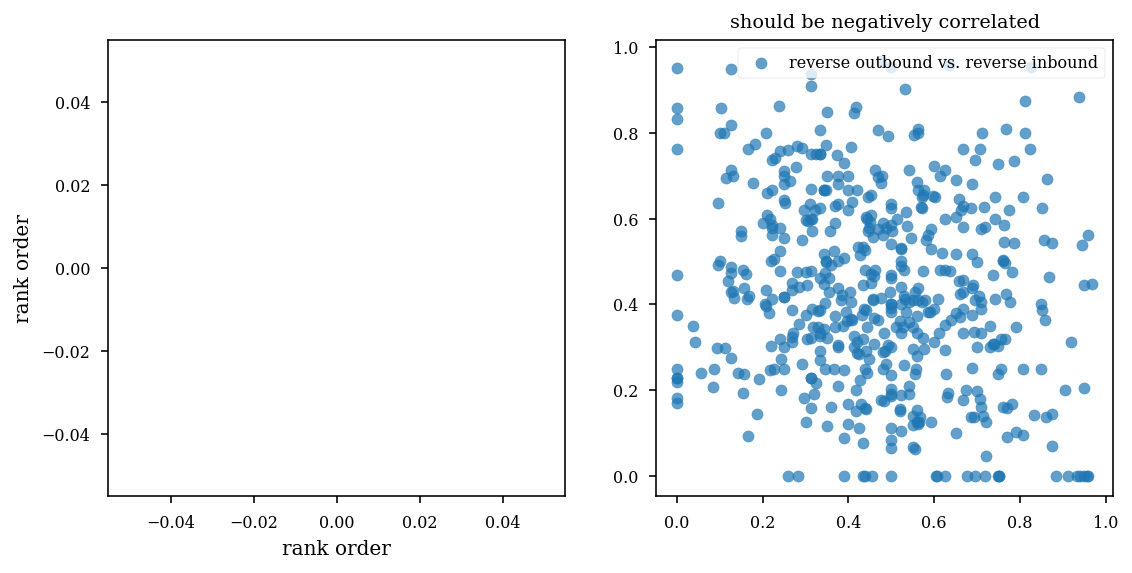

In [278]:
df_rank_order = pd.DataFrame()
df_rank_order['median_rank_order'] = np.hstack(median_rank_order)
df_rank_order['label'] = np.hstack(label)

fig,ax = plt.subplots(1,2,figsize=(9,9))

# ax[0].scatter(df_rank_order[df_rank_order.label == 'forward_outbound_replay'].median_rank_order,
#             df_rank_order[df_rank_order.label == 'reverse_inbound_replay'].median_rank_order,alpha=.7,
#             label='forward outbound vs. reverse inbound')

# ax[0].scatter(df_rank_order[df_rank_order.label == 'forward_inbound_replay'].median_rank_order,
#             df_rank_order[df_rank_order.label == 'reverse_outbound_replay'].median_rank_order,alpha=.7,
#             label='forward inbound vs. reverse outbound')
# ax[0].legend()
# ax[0].set_title('should be positively correlated')

# ax[1].scatter(df_rank_order[df_rank_order.label == 'forward_outbound_replay'].median_rank_order,
#             df_rank_order[df_rank_order.label == 'forward_inbound_replay'].median_rank_order,alpha=.7,
#             label='forward outbound vs. forward inbound')

ax[1].scatter(df_rank_order[df_rank_order.label == 'reverse_outbound_replay'].median_rank_order,
            df_rank_order[df_rank_order.label == 'forward_outbound_replay'].median_rank_order,alpha=.7,
            label='reverse outbound vs. reverse inbound')
ax[1].set_title('should be negatively correlated')
ax[1].legend()

ax[0].axis('square')
ax[1].axis('square')

ax[0].set_xlabel('rank order')
ax[0].set_ylabel('rank order')


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6732: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6732: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6732: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\ana

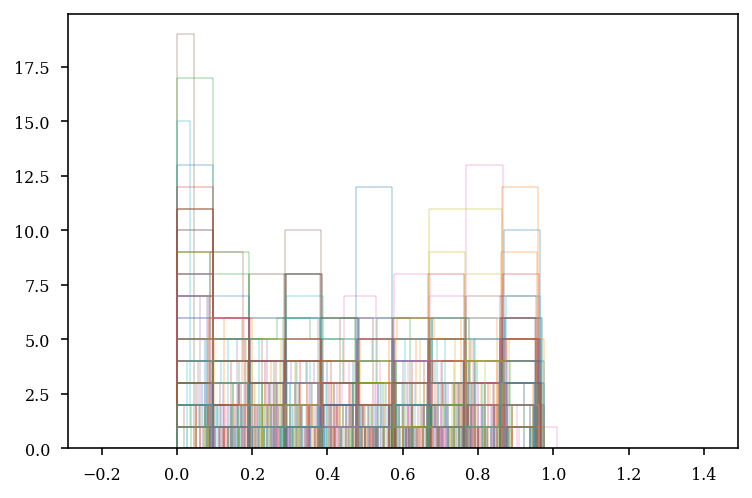

In [218]:
for i in range(rank_order.shape[0]):
    try:
        plt.hist(rank_order[i,:],histtype='step')
    except:
        pass
# plt.hist(rank_order[0,:],histtype='step')

plt.show()

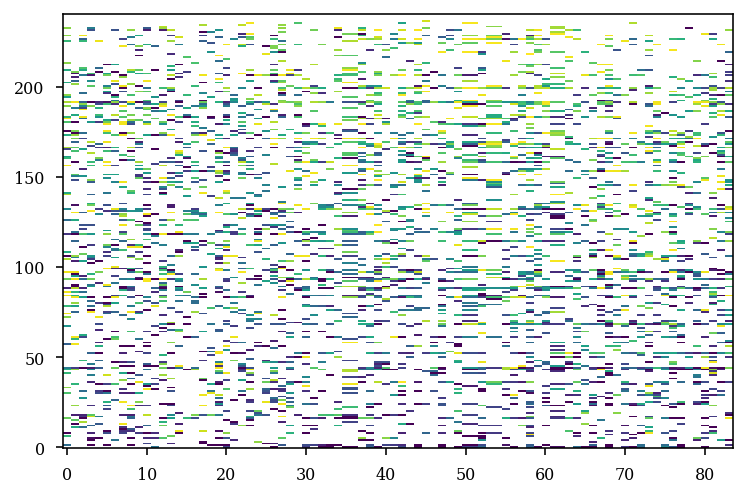

In [219]:
# plt.plot(np.sort(mean_rank))
plt.imshow(rank_order[np.argsort(mean_rank),:],aspect='auto',interpolation='nearest',origin='lower')

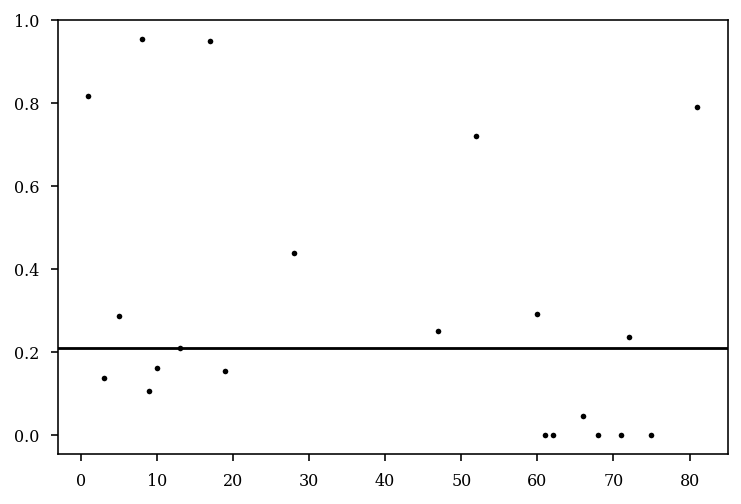

In [222]:
cell = 20
plt.plot(rank_order[cell,:],'.k')
plt.axhline(mean_rank[cell],color='k')

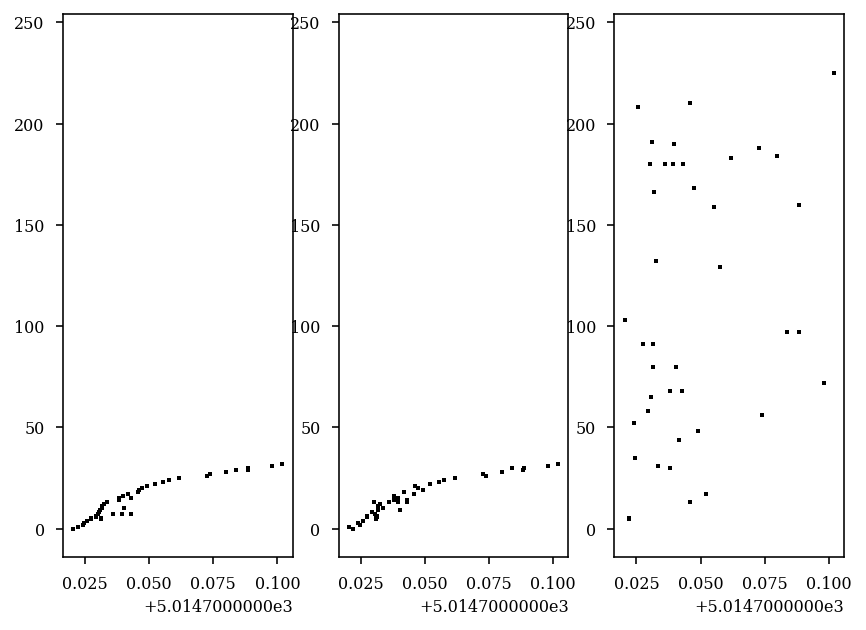

In [221]:
rip = 4

fig,ax = plt.subplots(1,3,figsize=(7,5))

order_idx = np.array(st[forward_replay[rip]].get_event_firing_order())-1
ax[0].eventplot(st[forward_replay[rip]].data[order_idx],linewidths=2,linelengths=2,color='k')

ax[1].eventplot(st[forward_replay[rip]].data[np.argsort(rank_order[:,rip])],linewidths=2,linelengths=2,color='k')

ax[2].eventplot(st[forward_replay[rip]].data[np.argsort(mean_rank)],linewidths=2,linelengths=2,color='k')

# ax[0].set_ylim(0,50)
# ax[1].set_ylim(0,50)

plt.show()

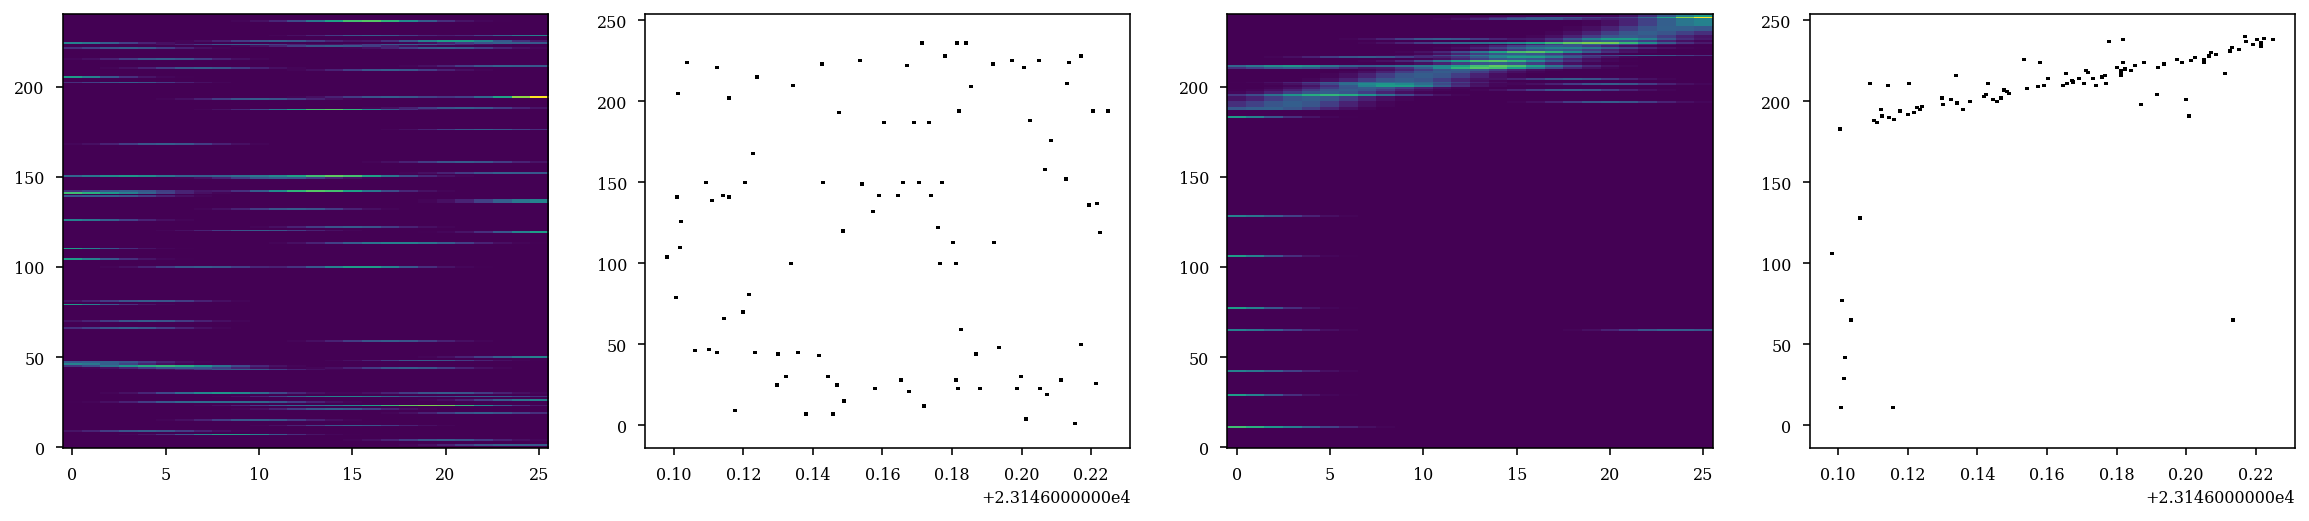

In [103]:
rip = 50
z_t = st[forward_replay[rip]].bin(ds=.005)
z_t.smooth(sigma=0.01,inplace=True)

fig,ax = plt.subplots(1,4,figsize=(20,4))
ax[0].imshow(z_t.data,aspect='auto',interpolation='nearest',origin='lower')
ax[1].eventplot(st[forward_replay[rip]].data,linewidths=2,linelengths=2,color='k')

peak_idx = []
for unit in z_t.data:
    peak_idx.append(np.argmax(unit))
reorder_idx = np.argsort(peak_idx)

ax[2].imshow(z_t.data[reorder_idx,:],aspect='auto',interpolation='nearest',origin='lower')

ax[3].eventplot(st[forward_replay[rip]].data[reorder_idx],linewidths=2,linelengths=2,color='k')
plt.show()

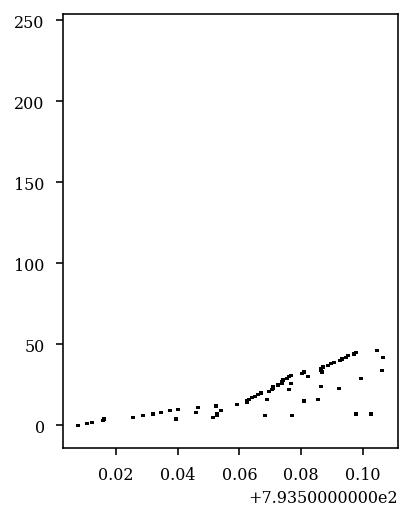

In [52]:
rip = 0
order_idx = np.array(st[forward_replay[rip]].get_event_firing_order())-1

plt.figure(figsize=(3,4))
plt.eventplot(st[forward_replay[rip]].data[order_idx],linewidths=2,linelengths=2,color='k')
plt.show()

# plt.figure()
# ax = plt.gca()
# raster_lw=2
# raster_lh=2
# npl.rasterplot(st[forward_replay[0]], vertstack=True, ax=ax, lh=raster_lh,lw=raster_lw)


In [27]:
results.keys()

dict_keys(['outbound_epochs', 'inbound_epochs'])

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


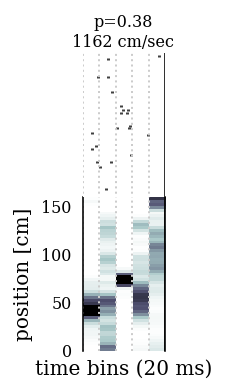

In [33]:
# importlib.reload(replay_fig)
import replay_fig
idxs = np.where((results['outbound_epochs']['df']['score_pval_col_cycle']<0.05))[0]
idx = idxs[0]
idx = int(idx)
if isinstance(idx, int):
    title = "p={:.2f}\n{:.0f} cm/sec".format(results['outbound_epochs']['df'].trajectory_score.iloc[idx],
                                             results['outbound_epochs']['df'].traj_speed.iloc[idx])
else:
    title = ""
ax = replay_fig.plot_all_replay(results['outbound_epochs']['bst_placecells'][idx],
                                        results['outbound_epochs']['sta_placecells'],
                                        results['outbound_epochs']['tc'],
                                        results['outbound_epochs']['tc'],
                                        vmax=.1,
                                        title_str=title) 